In [ ]:
# https://www.tensorflow.org/guide/core/logistic_regression_core

import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Preset matplotlib figure sizes.
def set_default_matplotlib_figsize():
  matplotlib.rcParams['figure.figsize'] = [6.4, 4.8]
  matplotlib.rcParams['savefig.dpi'] = 72

set_default_matplotlib_figsize()

# Data generation utils

In [ ]:
def draw_samples_for_linear_regression(n, theta, sigma_X, sigma_noise, seed=0):
  """
  Draws n samples from y = X * theta + N(0, sigma_noise^2), where X ~ N(0, sigma_X^2).
  """
  np.random.seed(seed)
  X = np.random.normal(0, sigma_X, (n, theta.shape[0])).astype(np.float32)
  y = (X @ theta + np.random.normal(0, sigma_noise, n)).astype(np.float32)
  thetas = np.tile(theta, (n, 1)).astype(np.float32)
  return X, y, thetas

def draw_samples_for_logistic_regression(n, theta, sigma_X, sigma_noise, binary_label=False, seed=0):
  """
  Draws n samples from y = sigmoid(X * theta + N(0, sigma_noise^2)), where X ~ N(0, sigma_X^2).
  """
  np.random.seed(seed)
  X = np.random.normal(0, sigma_X, (n, theta.shape[0])).astype(np.float32)
  y = tf.sigmoid(X @ theta + np.random.normal(0, sigma_noise, n)).numpy().astype(np.float32)
  thetas = np.tile(theta, (n, 1)).astype(np.float32)
  if binary_label:
    y = np.round(y)
  return X, y, thetas

#X, y, thetas = draw_samples_for_linear_regression(10, np.array([-1, 1]), sigma_X=0.1, sigma_noise=0.1)
#X, y, thetas = draw_samples_for_logistic_regression(10, np.array([-1, 1]), sigma_X=0.1, sigma_noise=0.1, binary_label=True)

In [ ]:
def draw_samples_from_theta_sequence(thetas, num_samples_per_theta, model_type, sigma_X, sigma_noise, binary_label=False, seed=0):
  assert model_type in ['linear_regression', 'logistic_regression']
  X_all = []
  y_all = []
  thetas_all = []
  for i in range(len(thetas)):
    if model_type == 'linear_regression':
      X, y, theta = draw_samples_for_linear_regression(num_samples_per_theta, thetas[i], sigma_X, sigma_noise, seed)
    elif model_type == 'logistic_regression':
      X, y, theta = draw_samples_for_logistic_regression(num_samples_per_theta, thetas[i], sigma_X, sigma_noise, binary_label, seed)
    seed += 1
    X_all.append(X)
    y_all.append(y)
    thetas_all.append(theta)
  X_all = np.concatenate(X_all)
  y_all = np.concatenate(y_all)
  thetas_all = np.concatenate(thetas_all)
  return X_all, y_all, thetas_all

#thetas = np.array([[1, -1], [-1, 1]])
#X, y, thetas = draw_samples_from_theta_sequence(thetas, 5, 'linear_regression', 1.0, 0.1)
#X, y, thetas = draw_samples_from_theta_sequence(thetas, 5, 'logistic_regression', 1.0, 0.1, binary_label=False)

# Model and loss function definitions

In [ ]:
class LinearRegression(tf.Module):
  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call.
    if not self.built:
      # Randomly generate the weights.
      #rand_w = tf.random.uniform(shape=[x.shape[-1], 1])
      rand_w = tf.zeros(shape=[x.shape[-1], 1])
      self.w = tf.Variable(rand_w)
      self.built = True
    # Compute the model output
    z = tf.matmul(x, self.w)
    z = tf.squeeze(z, axis=1)
    return z

def least_squares(y, y_hat):
  squared_errors = tf.math.square(tf.math.subtract(y, y_hat))
  return tf.reduce_mean(squared_errors)

In [ ]:
class LogisticRegression(tf.Module):
  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call.
    if not self.built:
      # Randomly generate the weights.
      #rand_w = tf.random.uniform(shape=[x.shape[-1], 1])
      rand_w = tf.zeros(shape=[x.shape[-1], 1])
      self.w = tf.Variable(rand_w)
      self.built = True
    # Compute the model output
    z = tf.matmul(x, self.w)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

def log_loss(labels, logits):
  cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
  return tf.reduce_mean(cross_entropy)

# Main online learning algorithm


In [ ]:
# TODO(fahrbach): Implement Adam?
# TODO(farhbach): Support `thetas = None` if we don't know optimal weights.
def run_online_learning_algorithm(X, y, thetas, batch_size, model_type, learning_rate_schedule):
  assert X.shape[0] == y.shape[0]
  assert X.shape[0] % batch_size == 0
  dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size)

  if model_type == 'linear_regression':
    model = LinearRegression()
    optimal_model = LinearRegression()
  elif model_type == 'logistic_regression':
    model = LogisticRegression()
    optimal_model = LogisticRegression()
  else:
    assert False

  # Unpack different learning rate schedule parameters
  assert len(learning_rate_schedule) == 1
  learning_rate_schedule_type = list(learning_rate_schedule.keys())[0]
  #print('learning_rate_schedule_type:', learning_rate_schedule_type)
  assert learning_rate_schedule_type in ['constant', 'our-algorithm-v1', 'our-algorithm-v2', 'our-algorithm-v3', 'our-algorithm-v4']
  learning_rate_params = learning_rate_schedule[learning_rate_schedule_type]
  #print('learning_rate_params:', learning_rate_params)

  losses_hat = []
  losses_opt = []
  thetas_hat = []
  thetas_opt = []
  step_sizes = []
  step = 0
  for X_batch, y_batch in dataset:
    # Get batch loss from oracle model if we know the optimal weights.
    theta_opt = thetas[step * batch_size]
    theta_opt = theta_opt.reshape((theta_opt.shape[-1], 1))
    unused_y_opt = optimal_model(X_batch)  # Initializes optimal_model's weights
    thetas_opt.append(theta_opt)
    optimal_model.variables[0].assign(theta_opt)
    if model_type == 'linear_regression':
      losses_opt.append(least_squares(y_batch, optimal_model(X_batch)))
    elif model_type == 'logistic_regression':
      losses_opt.append(log_loss(y_batch, optimal_model(X_batch)))

    with tf.GradientTape() as tape:
      if model_type == 'linear_regression':
        mean_batch_loss_hat = least_squares(y_batch, model(X_batch))
      elif model_type == 'logistic_regression':
        mean_batch_loss_hat = log_loss(y_batch, model(X_batch))

    grads = tape.gradient(mean_batch_loss_hat, model.variables)
    thetas_hat.append(model.variables[0].numpy())

    # TODO(fahrbach): Ensure that we only loop over grad once.
    for grad, vars in zip(grads, model.variables):
      # Learning rate schedule algorithms
      step_size = None

      if learning_rate_schedule_type == 'constant':
        step_size = learning_rate_params['step_size']

      elif learning_rate_schedule_type == 'our-algorithm-v1':
        sigma = learning_rate_params['sigma']
        b = learning_rate_params['batch_size']  # batch_size is already a param
        d = learning_rate_params['dimension']
        kappa_inv = learning_rate_params['kappa_inverse']
        kappa = 1.0 / kappa_inv

        # Compute gamma_t
        theta_opt_t = thetas[step * batch_size]
        theta_opt_t = theta_opt_t.reshape((theta_opt_t.shape[-1], 1))
        if (step + 1)*batch_size < thetas.shape[0]:
          theta_opt_tn = thetas[(step + 1) * batch_size]
          theta_opt_tn = theta_opt_tn.reshape((theta_opt_tn.shape[-1], 1))
        else:
          theta_opt_tn = theta_opt_t
        gamma = np.linalg.norm(theta_opt_t - theta_opt_tn)

        if step == 0:
          u = np.linalg.norm(thetas_hat[-1] - thetas_opt[-1])**2
        for k in range(kappa_inv):
          num = u**2 * b
          den = (d + 1)*u + sigma**2 * d
          u = u - kappa * (num / den) + 2 * kappa * gamma * np.sqrt(u)
        num = u
        den = (d + 1)*u + sigma**2 * d
        step_size = (num / den) * b

      elif learning_rate_schedule_type == 'our-algorithm-v2':
        sigma = learning_rate_params['sigma']
        b = learning_rate_params['batch_size']  # batch_size is already a param
        d = learning_rate_params['dimension']
        kappa_inv = learning_rate_params['kappa_inverse']
        kappa = 1.0 / kappa_inv
        C = learning_rate_params['max_step_size']

        # Compute gamma_t
        theta_opt_t = thetas[step * batch_size]
        theta_opt_t = theta_opt_t.reshape((theta_opt_t.shape[-1], 1))
        if (step + 1)*batch_size < thetas.shape[0]:
          theta_opt_tn = thetas[(step + 1) * batch_size]
          theta_opt_tn = theta_opt_tn.reshape((theta_opt_tn.shape[-1], 1))
        else:
          theta_opt_tn = theta_opt_t
        gamma = np.linalg.norm(theta_opt_t - theta_opt_tn)

        if step == 0:
          u = np.linalg.norm(thetas_hat[-1] - thetas_opt[-1])**2
          #u = 0.0
        for k in range(kappa_inv):
          term1 = kappa * ((d + 1) / b * step_size**2 - 2 * step_size) * u
          term2 = kappa * sigma**2 * d / b * step_size**2
          term3 = 2 * kappa * gamma * np.sqrt(u)
          u = u - term1 + term2 + term3
        num = u * b
        den = (d + 1)*u + sigma**2 * d
        step_size = min(num / den, C)

      elif learning_rate_schedule_type == 'our-algorithm-v3':
        sigma = learning_rate_params['sigma']
        b = learning_rate_params['batch_size']  # batch_size is already a param
        d = learning_rate_params['dimension']
        kappa_inv = learning_rate_params['kappa_inverse']
        kappa = 1.0 / kappa_inv
        C = learning_rate_params['max_step_size']

        # Compute gamma_t
        theta_opt_t = thetas[step * batch_size]
        theta_opt_t = theta_opt_t.reshape((theta_opt_t.shape[-1], 1))
        if (step + 1) * batch_size < thetas.shape[0]:
          theta_opt_tn = thetas[(step + 1) * batch_size]
          theta_opt_tn = theta_opt_tn.reshape((theta_opt_tn.shape[-1], 1))
        else:
          theta_opt_tn = theta_opt_t
        gamma = np.linalg.norm(theta_opt_t - theta_opt_tn)

        if step == 0:
          u = np.linalg.norm(thetas_hat[-1] - thetas_opt[-1])**2
        for k in range(kappa_inv):
          num = u * b
          den = (d + 1)*u + sigma**2 * d
          r = min(num/den, C)
          term1 = kappa * ((d + 1) / b * r**2 - 2 * r) * u
          term2 = kappa * sigma**2 * d / b * r**2
          term3 = 2 * kappa * gamma * np.sqrt(u)
          u = u + term1 + term2 + term3
        num = u * b
        den = (d + 1)*u + sigma**2 * d
        step_size = min(num / den, C)

      # Proposition 4.3 (Learning rate scheudle) in the paper.
      elif learning_rate_schedule_type == 'our-algorithm-v4':
        b = learning_rate_params['batch_size']  # batch_size is already a param
        d = learning_rate_params['dimension']
        D_max = learning_rate_params['D_max']
        step_size_v4 = learning_rate_params['step_size']

        if model_type == 'logistic_regression':
          L = 0.25
          #L = 0.2 / D_max
          #L = 1.0 / step_size_v4
          sigma = np.sqrt(d / 4)
        else:
          assert False

        # Compute gamma_t
        theta_opt_t = thetas[step * batch_size]
        theta_opt_t = theta_opt_t.reshape((theta_opt_t.shape[-1], 1))
        if (step + 1) * batch_size < thetas.shape[0]:
          theta_opt_tn = thetas[(step + 1) * batch_size]
          theta_opt_tn = theta_opt_tn.reshape((theta_opt_tn.shape[-1], 1))
        else:
          theta_opt_tn = theta_opt_t
        gamma = np.linalg.norm(theta_opt_t - theta_opt_tn)

        b1t = gamma**2 + 2 * D_max * gamma
        b2t = (gamma + D_max)**2
        tau_1t = b / (2 * sigma**2) * (np.sqrt(b1t**2 * L**2 + 4*sigma**2 / b * b1t) - b1t * L)
        tau_2t = b / (2 * sigma**2) * (np.sqrt(b2t**2 * L**2 + 4*sigma**2 / b * b2t) - b2t * L)
        #tau_1t = np.sqrt(b) / sigma * np.sqrt(gamma**2 + 2 * D_max * gamma)
        #tau_2t = np.sqrt(b) / sigma * (gamma + D_max)
        #print(' - b1t:', b1t, 'b2t:', b2t, 'tau_1t:', tau_1t, 'tau_2t:', tau_2t, 'gamma_t:', gamma, 'D_max:', D_max)

        if step == 0:
          step_size = tau_1t
        else:
          last_step_size = step_sizes[-1]
          if last_step_size <= tau_1t:
            step_size = tau_1t
          elif last_step_size <= tau_2t:
            step_size = last_step_size
          else:
            step_size = tau_2t
      else:
        assert False
      vars.assign_sub(step_size * grad)
    if False: #step <= 10 or step % 100 == 0:
      print('step:', step, 'step_size:', step_size, 'loss_hat:', mean_batch_loss_hat.numpy(), 'grad_norm:', tf.norm(grad))
    losses_hat.append(mean_batch_loss_hat)
    step_sizes.append(step_size)
    step += 1

  return np.array(losses_hat), np.array(losses_opt), np.array(tf.squeeze(thetas_hat)), np.array(tf.squeeze(thetas_opt)), np.array(step_sizes)

# Experiments

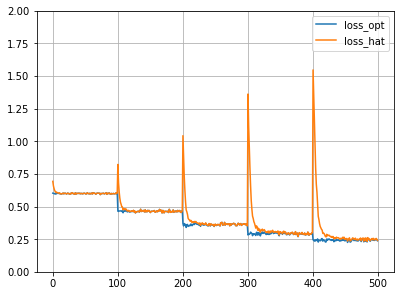

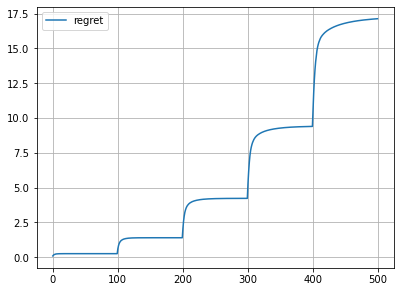

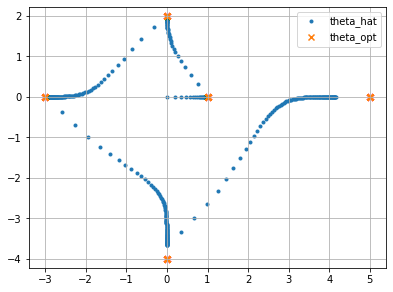

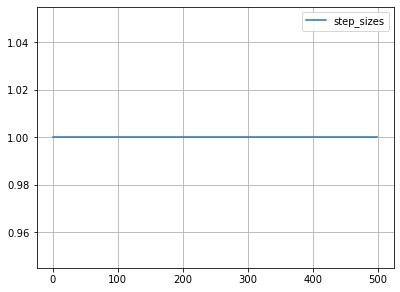

In [ ]:
# Logistic regression experiment

BATCH_SIZE = 1024
NUM_STEPS_PER_PHASE = 100
SIGMA_X = 1.0
SIGMA_NOISE = 0.1
BINARY_LABELS = False
MODEL_TYPE = 'logistic_regression'

# Generate sequence of data points
theta_sequence = np.array([[1, 0],
                           [0, 2],
                           [-3, 0],
                           [0, -4],
                           [5, 0]])
X, y, thetas = draw_samples_from_theta_sequence(theta_sequence, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE, BINARY_LABELS)

# Run online learning algorithm
learning_rate_schedule = {}
learning_rate_schedule['constant'] = {'step_size': 1.0}
losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)

# Plot results
plt.plot(losses_opt, label='loss_opt')
plt.plot(losses_hat, label='loss_hat')
plt.legend()
plt.grid()
plt.ylim([0, 2])
plt.show()

regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
plt.plot(regret, label='regret')
plt.legend()
plt.grid()
plt.show()

plt.scatter(thetas_hat[:,0], thetas_hat[:,1], marker='.', label='theta_hat')
plt.scatter(thetas_opt[:,0], thetas_opt[:,1], marker='x', label='theta_opt')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

plt.plot(step_sizes, label='step_sizes')
plt.legend()
plt.grid()
plt.show()

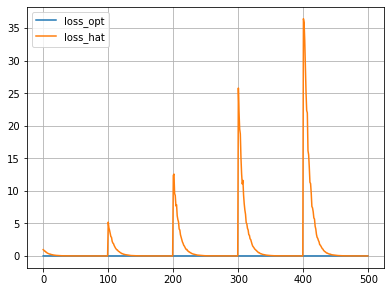

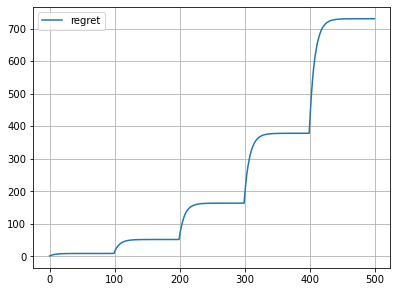

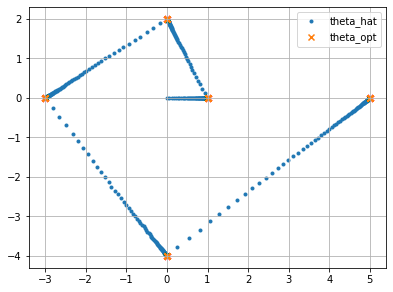

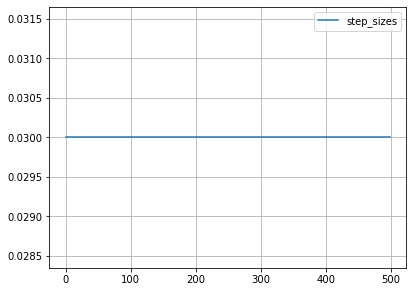

In [ ]:
# Linear regression experiment

BATCH_SIZE = 1024
NUM_STEPS_PER_PHASE = 100
SIGMA_X = 1.0
SIGMA_NOISE = 0.1
MODEL_TYPE = 'linear_regression'

# Generate sequence of data points
theta_sequence = np.array([[1, 0],
                           [0, 2],
                           [-3, 0],
                           [0, -4],
                           [5, 0]])
X, y, thetas = draw_samples_from_theta_sequence(theta_sequence, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE)

# Run online learning algorithm
learning_rate_schedule = {}
learning_rate_schedule['constant'] = {'step_size': 0.03}
losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)

# Plot results
plt.plot(losses_opt, label='loss_opt')
plt.plot(losses_hat, label='loss_hat')
plt.legend()
plt.grid()
plt.show()

regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
plt.plot(regret, label='regret')
plt.legend()
plt.grid()
plt.show()

plt.scatter(thetas_hat[:,0], thetas_hat[:,1], marker='.', label='theta_hat')
plt.scatter(thetas_opt[:,0], thetas_opt[:,1], marker='x', label='theta_opt')
plt.legend()
plt.grid()
plt.show()

plt.plot(step_sizes, label='step_sizes')
plt.legend()
plt.grid()
plt.show()

# step_size: 0.01
total_regret: 145.11797

# step_size: 0.03
total_regret: 126.92979

# step_size: 0.1
total_regret: 81.24096

# step_size: 0.3
total_regret: 42.07061

# step_size: 1
total_regret: 17.12865

# step_size: 3
total_regret: 6.903207

# step_size: 10
total_regret: 4.82534

# step_size: 30
total_regret: 207.90561



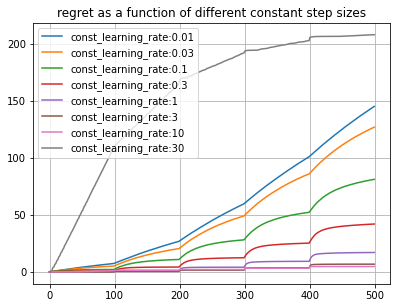

In [ ]:
# More sophisticated loop where we look at the regrets as a function of step size
BATCH_SIZE = 1024
NUM_STEPS_PER_PHASE = 100
SIGMA_X = 1.0
SIGMA_NOISE = 0.1
BINARY_LABELS = False
MODEL_TYPE = 'logistic_regression'

# Generate sequence of data points
theta_sequence = np.array([[1, 0],
                           [0, 2],
                           [-3, 0],
                           [0, -4],
                           [5, 0]])
X, y, thetas = draw_samples_from_theta_sequence(theta_sequence, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE, BINARY_LABELS)

# Run online learning algorithm
step_sizes = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
for step_size in step_sizes:
  print('# step_size:', step_size)
  learning_rate_schedule = {}
  learning_rate_schedule['constant'] = {'step_size': step_size}
  losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  print('total_regret:', regret[-1])
  print()
  plt.plot(regret, label='const_learning_rate:' + str(learning_rate_schedule['constant']['step_size']))

plt.title('regret as a function of different constant step sizes')
plt.grid()
plt.legend()
plt.show()

(512000, 128)
(512000,)
regret: 7917.3564


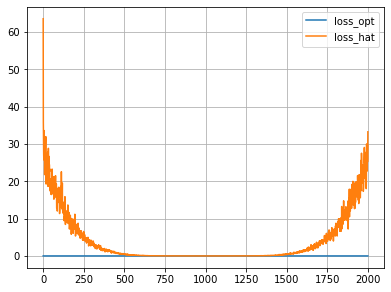

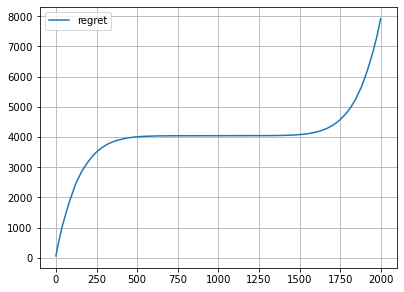

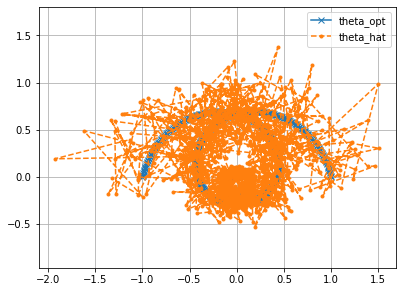

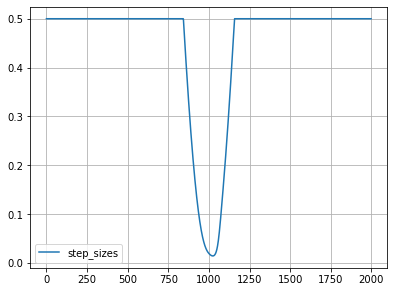

In [ ]:
# Sprial experiment (linear regression)
BATCH_SIZE = 256
NUM_STEPS_PER_PHASE = 1
SIGMA_X = 1.0
SIGMA_NOISE = 0.1
MODEL_TYPE = 'linear_regression'

NUM_REVOLUTIONS = 4
NUM_STEPS = 2000
DIMENSION = 128
angles = np.linspace(0, 2 * np.pi * NUM_REVOLUTIONS, num=NUM_STEPS)
radius = np.linspace(1, -1, num=NUM_STEPS)
radius = radius * radius * radius
theta_stars = []
for t in range(len(angles)):
  angle = angles[t]
  coords = []
  for d in range(DIMENSION):
    phase = (d // 2) + 1
    if d % 2 == 0:
      coords.append(np.cos(phase * angle))
    else:
      coords.append(np.sin(phase * angle))
  row_vec = radius[t] * np.array(coords)
  theta_stars.append(row_vec)
theta_stars = np.array(theta_stars)
X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE)

if DIMENSION == 2:
  plt.plot(thetas[:,0], thetas[:,1], marker='o', linestyle='-')
  plt.grid()
  plt.axis('equal')
  plt.show()
print(X.shape)
print(y.shape)

# Run online learning algorithm
learning_rate_schedule = {}
#learning_rate_schedule['constant'] = {'step_size': 0.03}
#learning_rate_schedule['our-algorithm-v1'] = {'sigma': SIGMA_NOISE, 'batch_size': 1, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE}
#learning_rate_schedule['our-algorithm-v2'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': 1}
learning_rate_schedule['our-algorithm-v3'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': 0.5}
losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
print('regret:', np.cumsum(np.array(losses_hat) - np.array(losses_opt))[-1])

# Plot results
plt.plot(losses_opt, label='loss_opt')
plt.plot(losses_hat, label='loss_hat')
plt.legend()
plt.grid()
plt.show()

regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
plt.plot(regret, label='regret')
plt.legend()
plt.grid()
plt.show()

plt.plot(thetas_opt[:,0], thetas_opt[:,1], linestyle='-', marker='x', label='theta_opt')
plt.plot(thetas_hat[:,0], thetas_hat[:,1], linestyle='--', marker='.', label='theta_hat')
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

plt.plot(step_sizes[:-1], label='step_sizes')
plt.legend()
plt.grid()
plt.show()

[[1 1]]


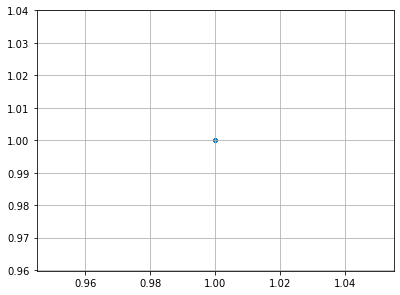

(128000, 2)
(128000,)
regret: 5.443018


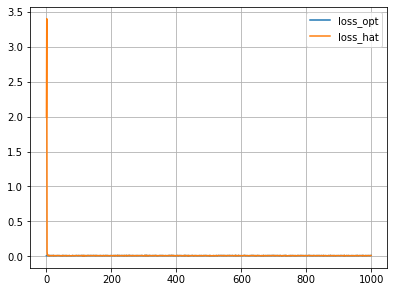

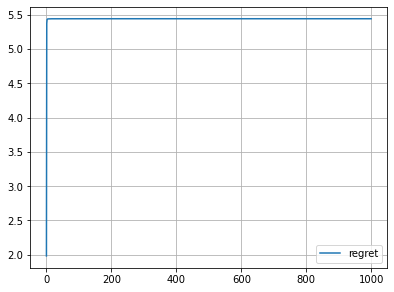

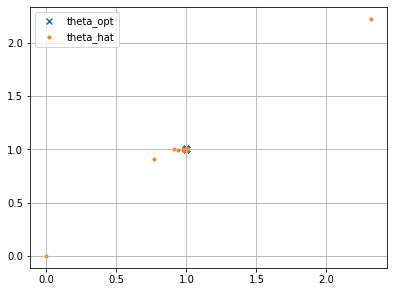

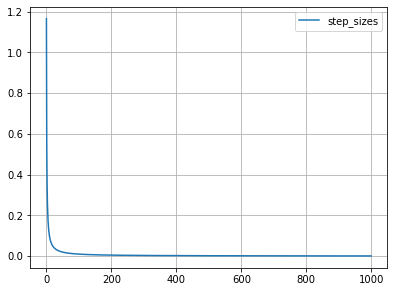

In [ ]:
# Linear regression without any drift (i.e., constant theta_t).
BATCH_SIZE = 128
NUM_STEPS_PER_PHASE = 1000
SIGMA_X = 1.0
SIGMA_NOISE = 0.1
MODEL_TYPE = 'linear_regression'

theta_stars = np.array([[1, 1]])
print(theta_stars)
X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE)

plt.scatter(thetas[:,0], thetas[:,1], marker='.')
plt.grid()
plt.axis('equal')
plt.show()
print(X.shape)
print(y.shape)

# Run online learning algorithm
learning_rate_schedule = {}
#learning_rate_schedule['constant'] = {'step_size': 0.8}
#learning_rate_schedule['our-algorithm-v1'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE}
#learning_rate_schedule['our-algorithm-v2'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': 1}
learning_rate_schedule['our-algorithm-v3'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': 100000}
losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
print('regret:', np.cumsum(np.array(losses_hat) - np.array(losses_opt))[-1])

# Plot results
plt.plot(losses_opt, label='loss_opt')
plt.plot(losses_hat, label='loss_hat')
plt.legend()
plt.grid()
plt.show()

regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
plt.plot(regret, label='regret')
plt.legend()
plt.grid()
plt.show()

plt.scatter(thetas_opt[:,0], thetas_opt[:,1], marker='x', label='theta_opt')
plt.scatter(thetas_hat[:,0], thetas_hat[:,1], marker='.', label='theta_hat')
plt.legend()
plt.grid()
plt.show()

plt.plot(step_sizes, label='step_sizes')
plt.legend()
plt.grid()
plt.show()

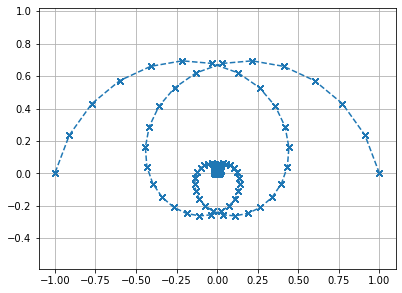

(256000, 32)
(256000,)
regret: 46.103992


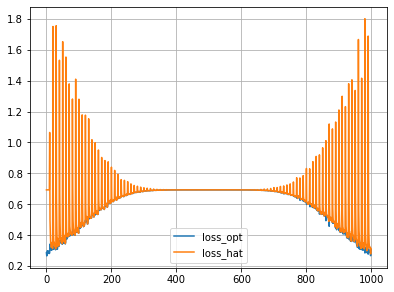

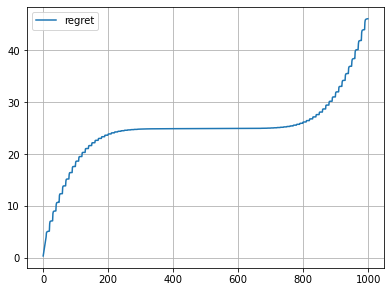

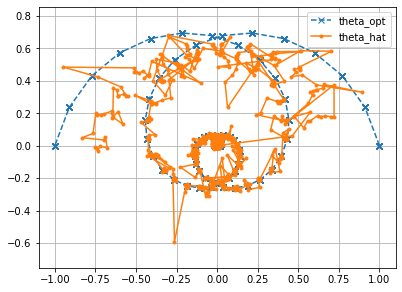

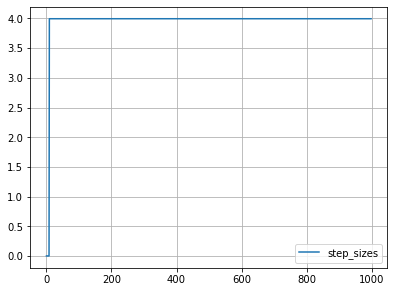

In [ ]:
# v4 logistic regression experiment
BATCH_SIZE = 256
NUM_STEPS_PER_PHASE = 10
SIGMA_X = 1.0
SIGMA_NOISE = 0.1
MODEL_TYPE = 'logistic_regression'
BINARY_LABEL=False

NUM_REVOLUTIONS = 4
NUM_STEPS = 100
DIMENSION = 32
angles = np.linspace(0, 2 * np.pi * NUM_REVOLUTIONS, num=NUM_STEPS)
radius = np.linspace(1, -1, num=NUM_STEPS)
radius = radius * radius * radius
theta_stars = []
for t in range(len(angles)):
  angle = angles[t]
  coords = []
  for d in range(DIMENSION):
    phase = (d // 2) + 1
    if d % 2 == 0:
      coords.append(np.cos(phase * angle))
    else:
      coords.append(np.sin(phase * angle))
  row_vec = radius[t] * np.array(coords)
  theta_stars.append(row_vec)
theta_stars = np.array(theta_stars)
X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE, BINARY_LABEL)

if DIMENSION >= 2:
  plt.plot(thetas[:,0], thetas[:,1], marker='x', linestyle='--')
  plt.grid()
  plt.axis('equal')
  plt.show()
print(X.shape)
print(y.shape)

# Run online learning algorithm
learning_rate_schedule = {}
#learning_rate_schedule['constant'] = {'step_size': 3}
#learning_rate_schedule['our-algorithm-v1'] = {'sigma': SIGMA_NOISE, 'batch_size': 1, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE}
#learning_rate_schedule['our-algorithm-v2'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': 1}
#learning_rate_schedule['our-algorithm-v3'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': 0.5}
learning_rate_schedule['our-algorithm-v4'] = {'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'D_max': DIMENSION, 'step_size': 0.5}
losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
print('regret:', np.cumsum(np.array(losses_hat) - np.array(losses_opt))[-1])

# Plot results
plt.plot(losses_opt, label='loss_opt')
plt.plot(losses_hat, label='loss_hat')
plt.legend()
plt.grid()
plt.show()

regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
plt.plot(regret, label='regret')
plt.legend()
plt.grid()
plt.show()

plt.plot(thetas_opt[:,0], thetas_opt[:,1], linestyle='--', marker='x', label='theta_opt')
plt.plot(thetas_hat[:,0], thetas_hat[:,1], linestyle='-', marker='.', label='theta_hat')
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

plt.plot(step_sizes[:-1], label='step_sizes')
plt.legend()
plt.grid()
plt.show()

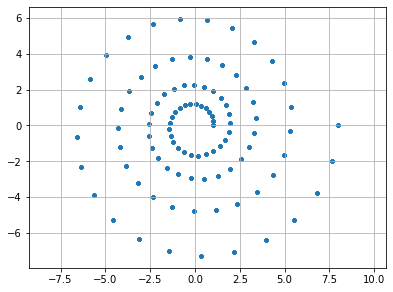

(1000, 4)
(1000,)
# constant-step-size
step_size: 0 total_regret: 36758.652

# algorithm-v3
step_size: 0 total_regret: 36758.652


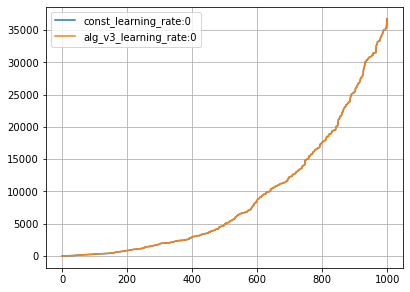

In [ ]:
# Sprial experiments
# Results: https://docs.google.com/spreadsheets/d/1hwNSLN9EncyKhOFsCWNshGwyeCpuGj-iacRydqlRnGA/edit?resourcekey=0-DPWbmp3D9qfXfP2w1DqmPg#gid=0
BATCH_SIZE = 1
NUM_STEPS_PER_PHASE = 10
SIGMA_X = 1.0
SIGMA_NOISE = 0.1
MODEL_TYPE = 'linear_regression'

NUM_REVOLUTIONS = 4
NUM_STEPS = 100
DIMENSION = 4
angles = np.linspace(0, 2 * np.pi * NUM_REVOLUTIONS, num=NUM_STEPS)
radius = np.linspace(1, 2, num=NUM_STEPS)
radius = radius * radius * radius
theta_stars = []
for t in range(len(angles)):
  angle = angles[t]
  coords = []
  for d in range(DIMENSION):
    phase = (d // 2) + 1
    if d % 2 == 0:
      coords.append(np.cos(phase * angle))
    else:
      coords.append(np.sin(phase * angle))
  row_vec = radius[t] * np.array(coords)
  theta_stars.append(row_vec)
theta_stars = np.array(theta_stars)
X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE)

plt.scatter(thetas[:,0], thetas[:,1], marker='.')
plt.grid()
plt.axis('equal')
plt.show()
print(X.shape)
print(y.shape)

# Run online learning algorithm
candidate_step_sizes = [0]
#candidate_step_sizes = [0, 0.01, 0.03, 0.1, 0.3, 1, 3]
#candidate_step_sizes = np.linspace(0.1, 1, num=19)
print('# constant-step-size')
for step_size in candidate_step_sizes:
  learning_rate_schedule = {}
  learning_rate_schedule['constant'] = {'step_size': step_size}
  losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  regret = np.cumsum(losses_hat - losses_opt)
  print('step_size:', step_size, 'total_regret:', regret[-1])
  plt.plot(regret, label='const_learning_rate:' + str(learning_rate_schedule['constant']['step_size']))

print('\n# algorithm-v3')
for step_size in candidate_step_sizes:
  learning_rate_schedule = {}
  learning_rate_schedule['our-algorithm-v3'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': step_size}
  losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  print('step_size:', step_size, 'total_regret:', regret[-1])
  plt.plot(regret, label='alg_v3_learning_rate:' + str(learning_rate_schedule['our-algorithm-v3']['max_step_size']))

plt.legend()
plt.grid()
plt.show()

# Figures in ICML 2023 submission

step_size: 0.003
regret: 5870.4414

step_size: 0.01
regret: 1652.0474

step_size: 0.03
regret: 516.4799

step_size: 0.1
regret: 220.76212

step_size: 0.003
regret: 5870.4414


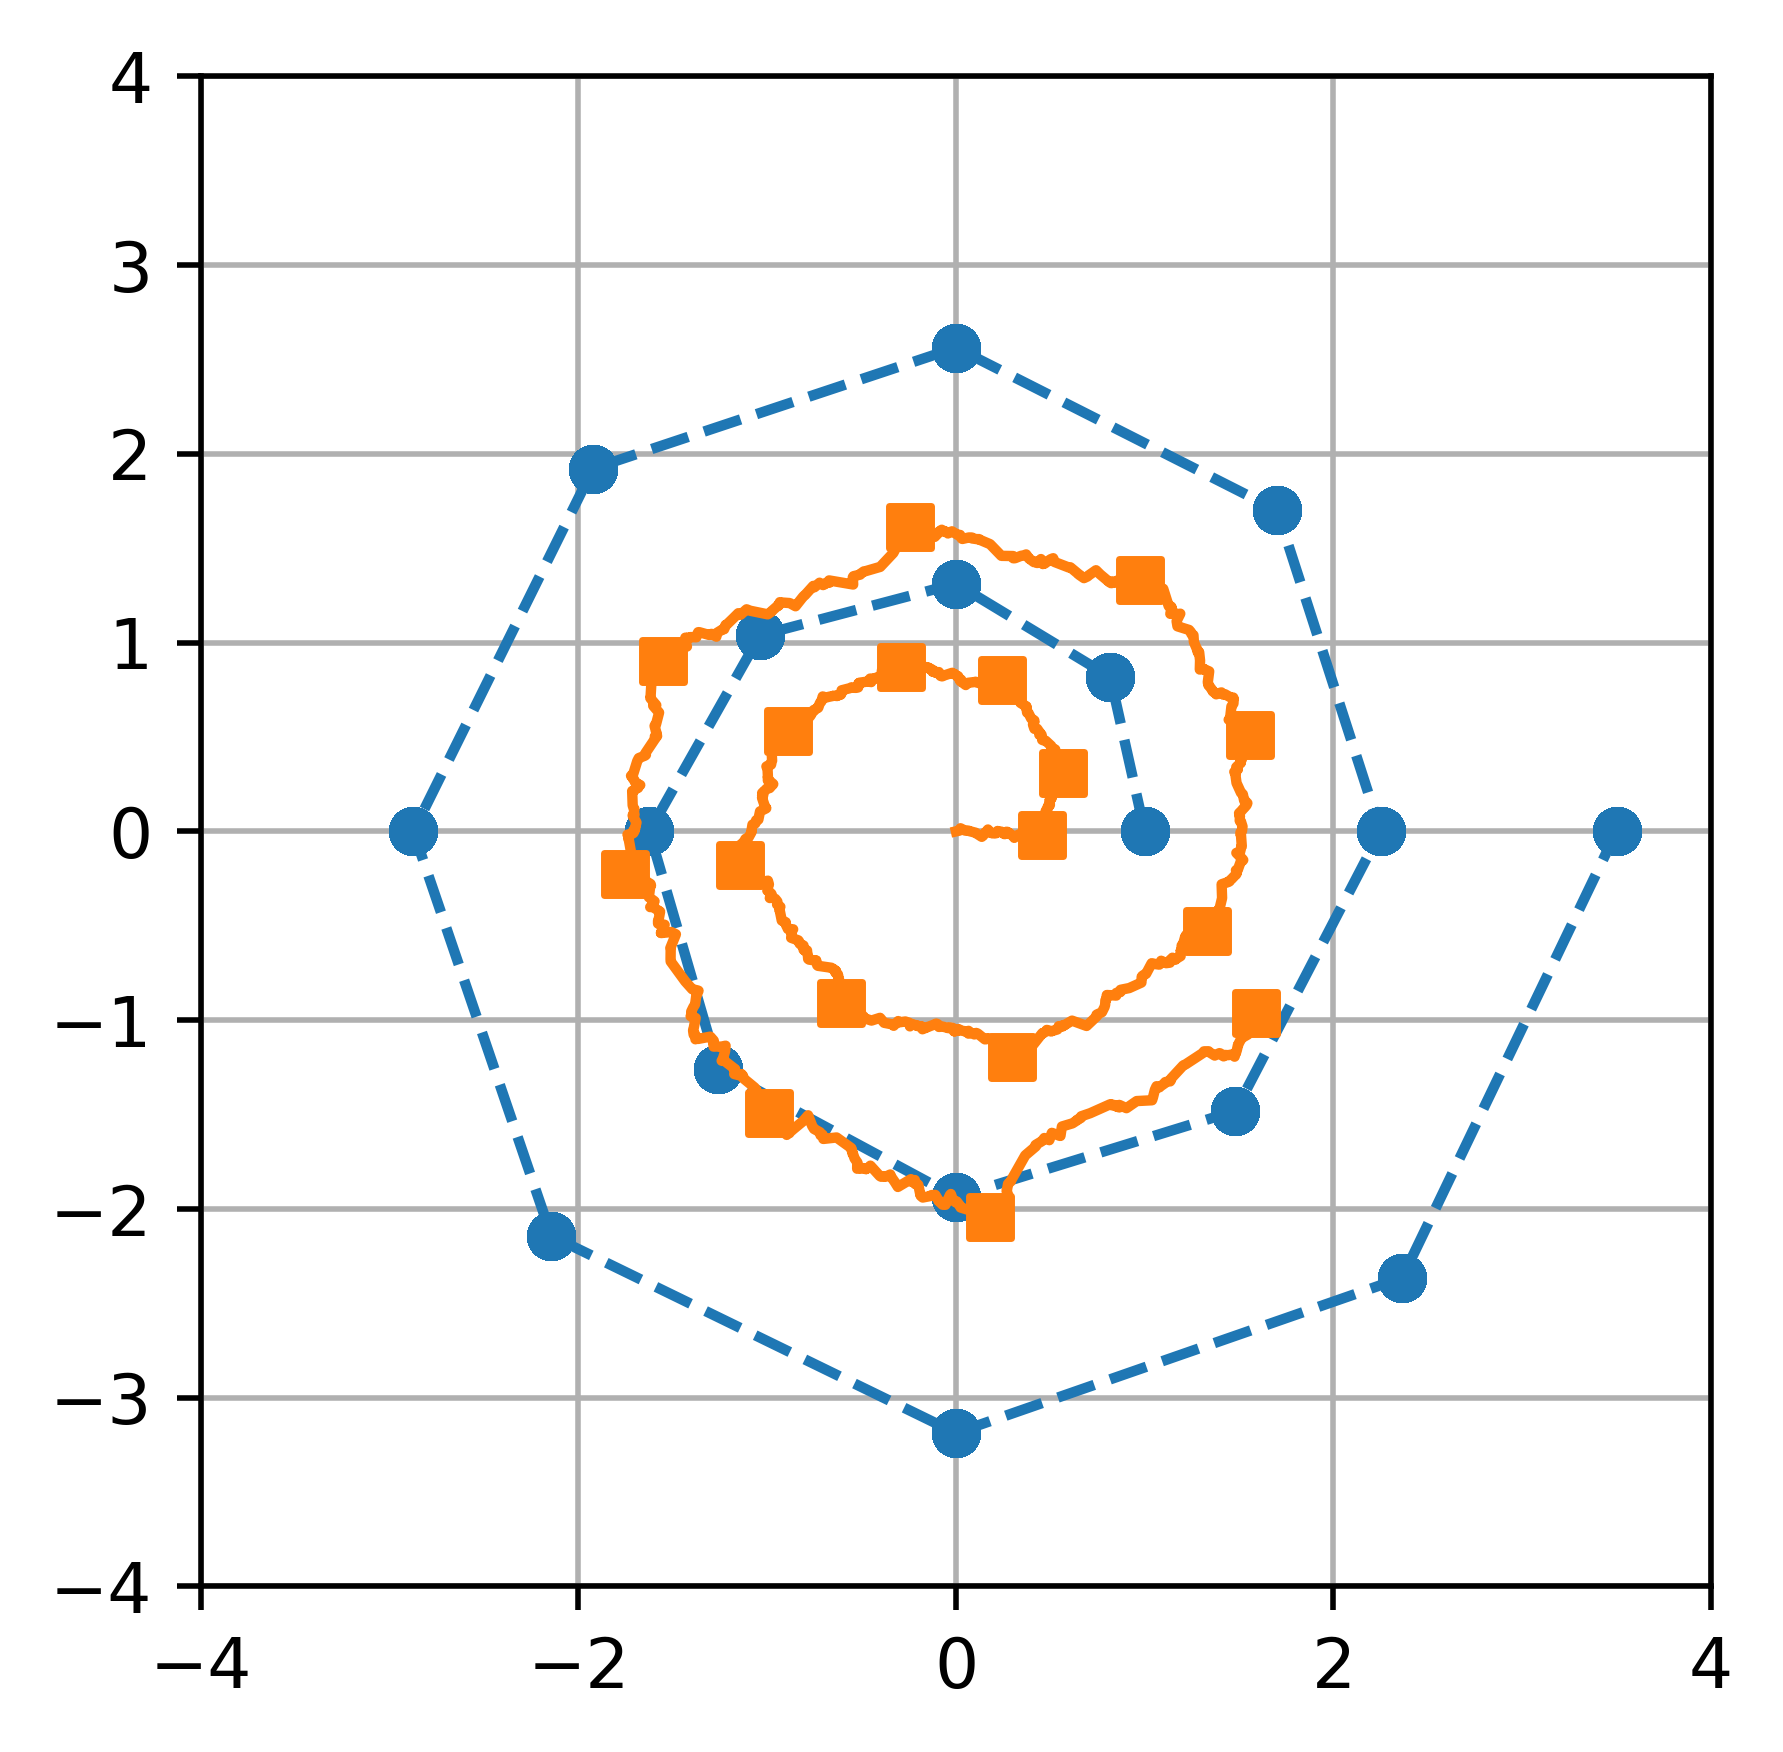

step_size: 0.01
regret: 1652.0474


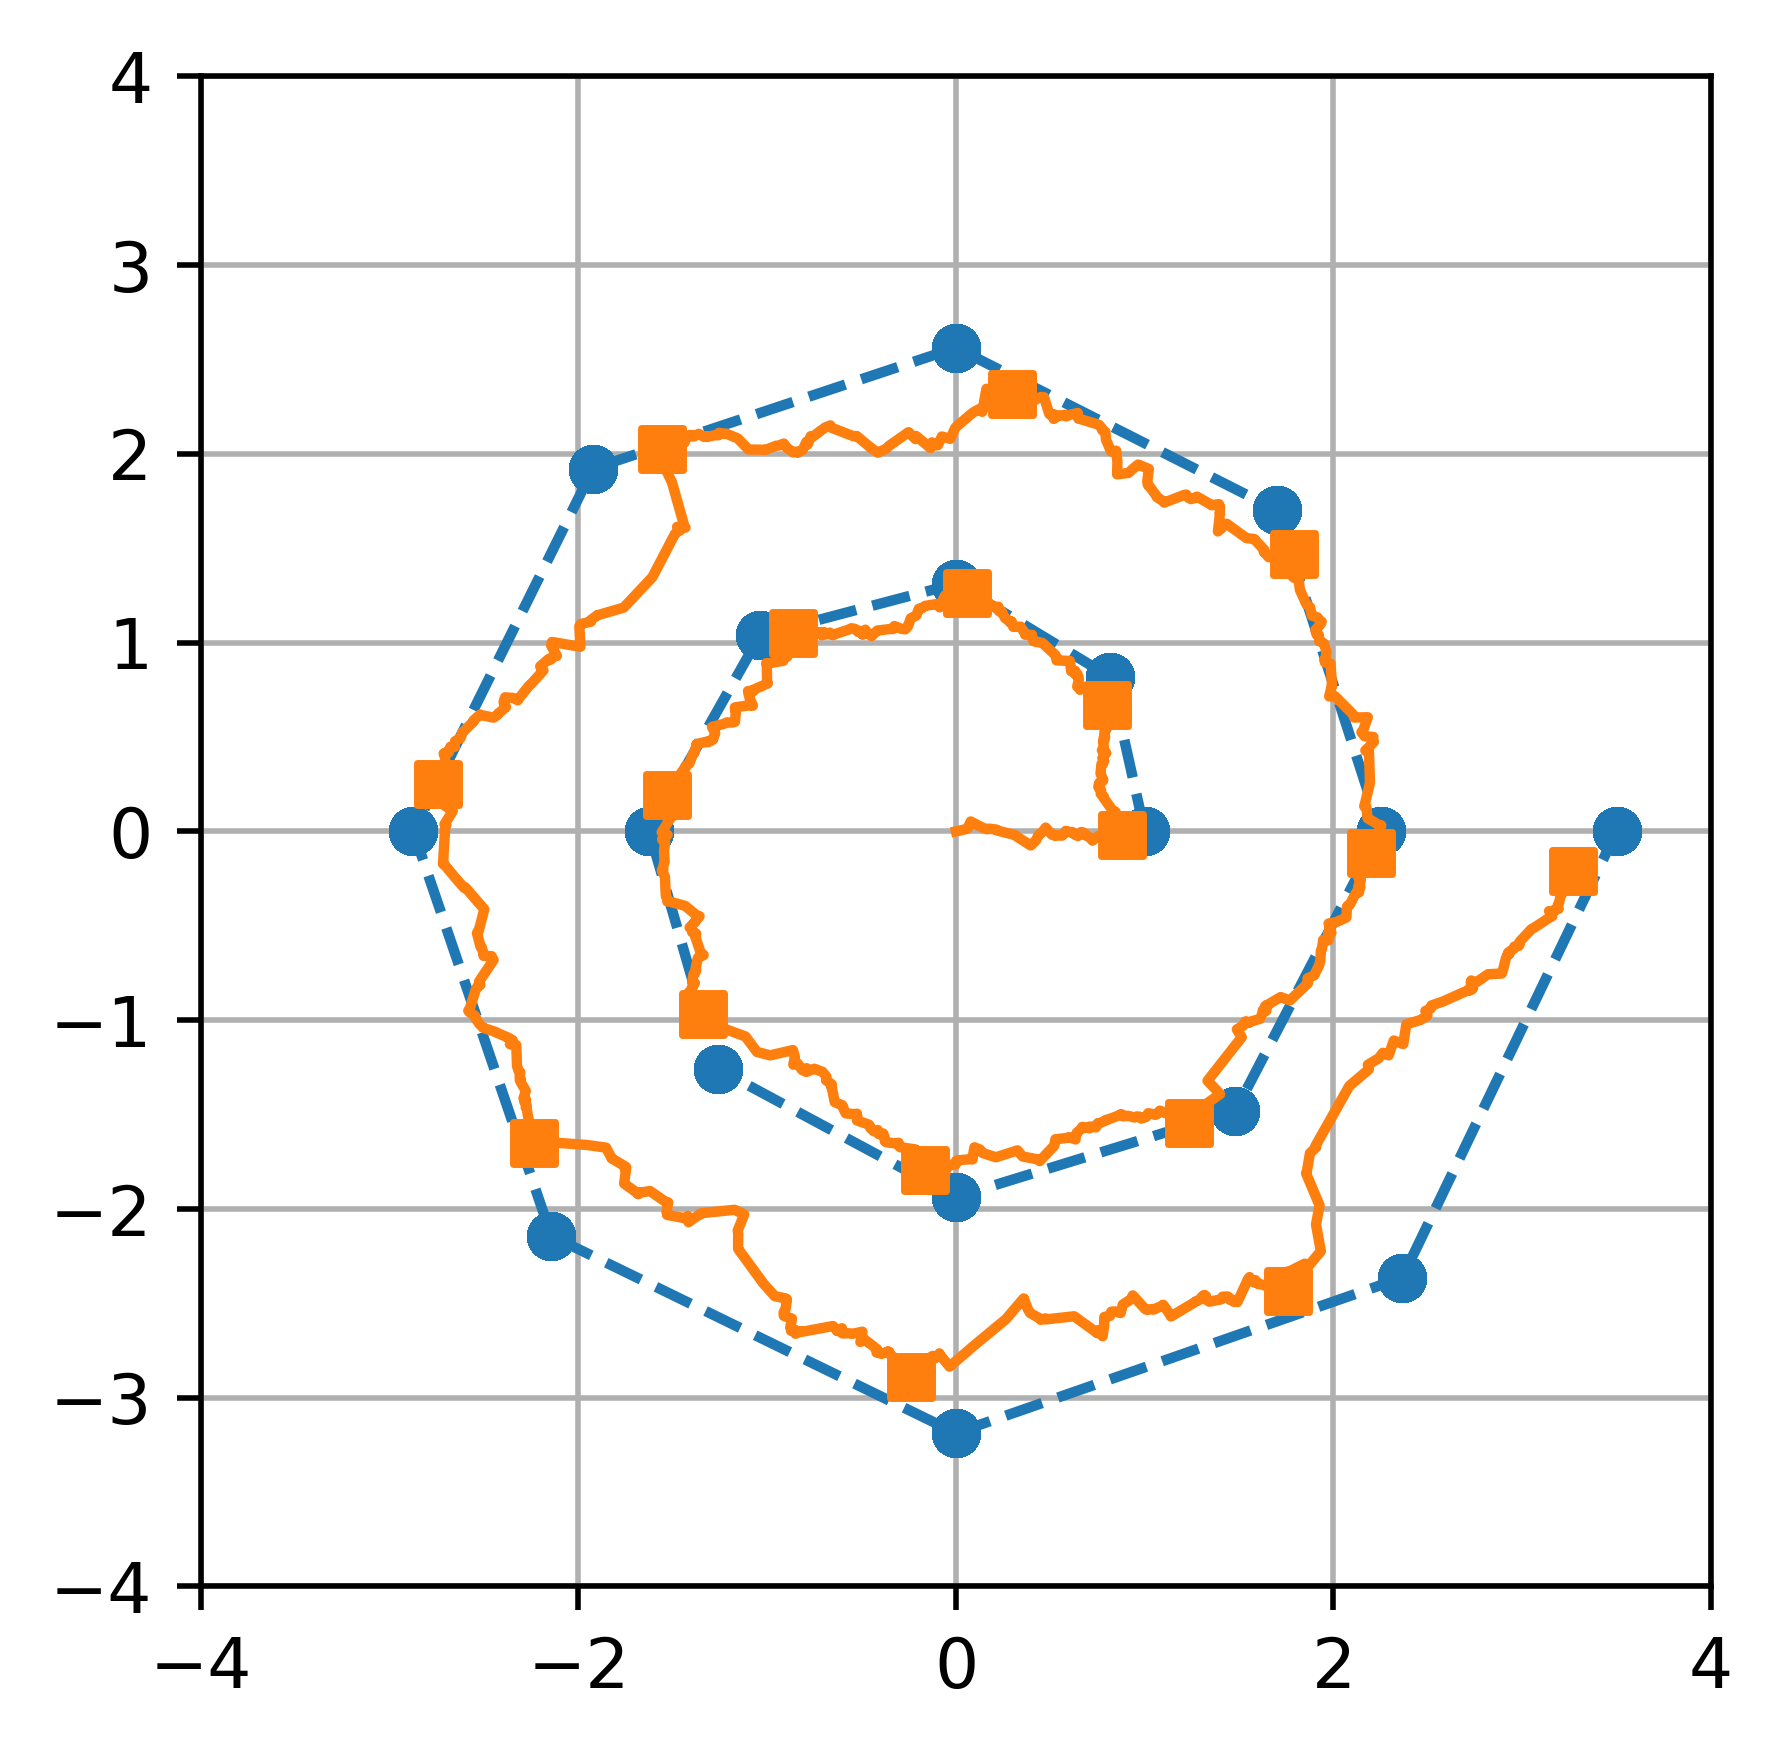

step_size: 0.03
regret: 516.4799


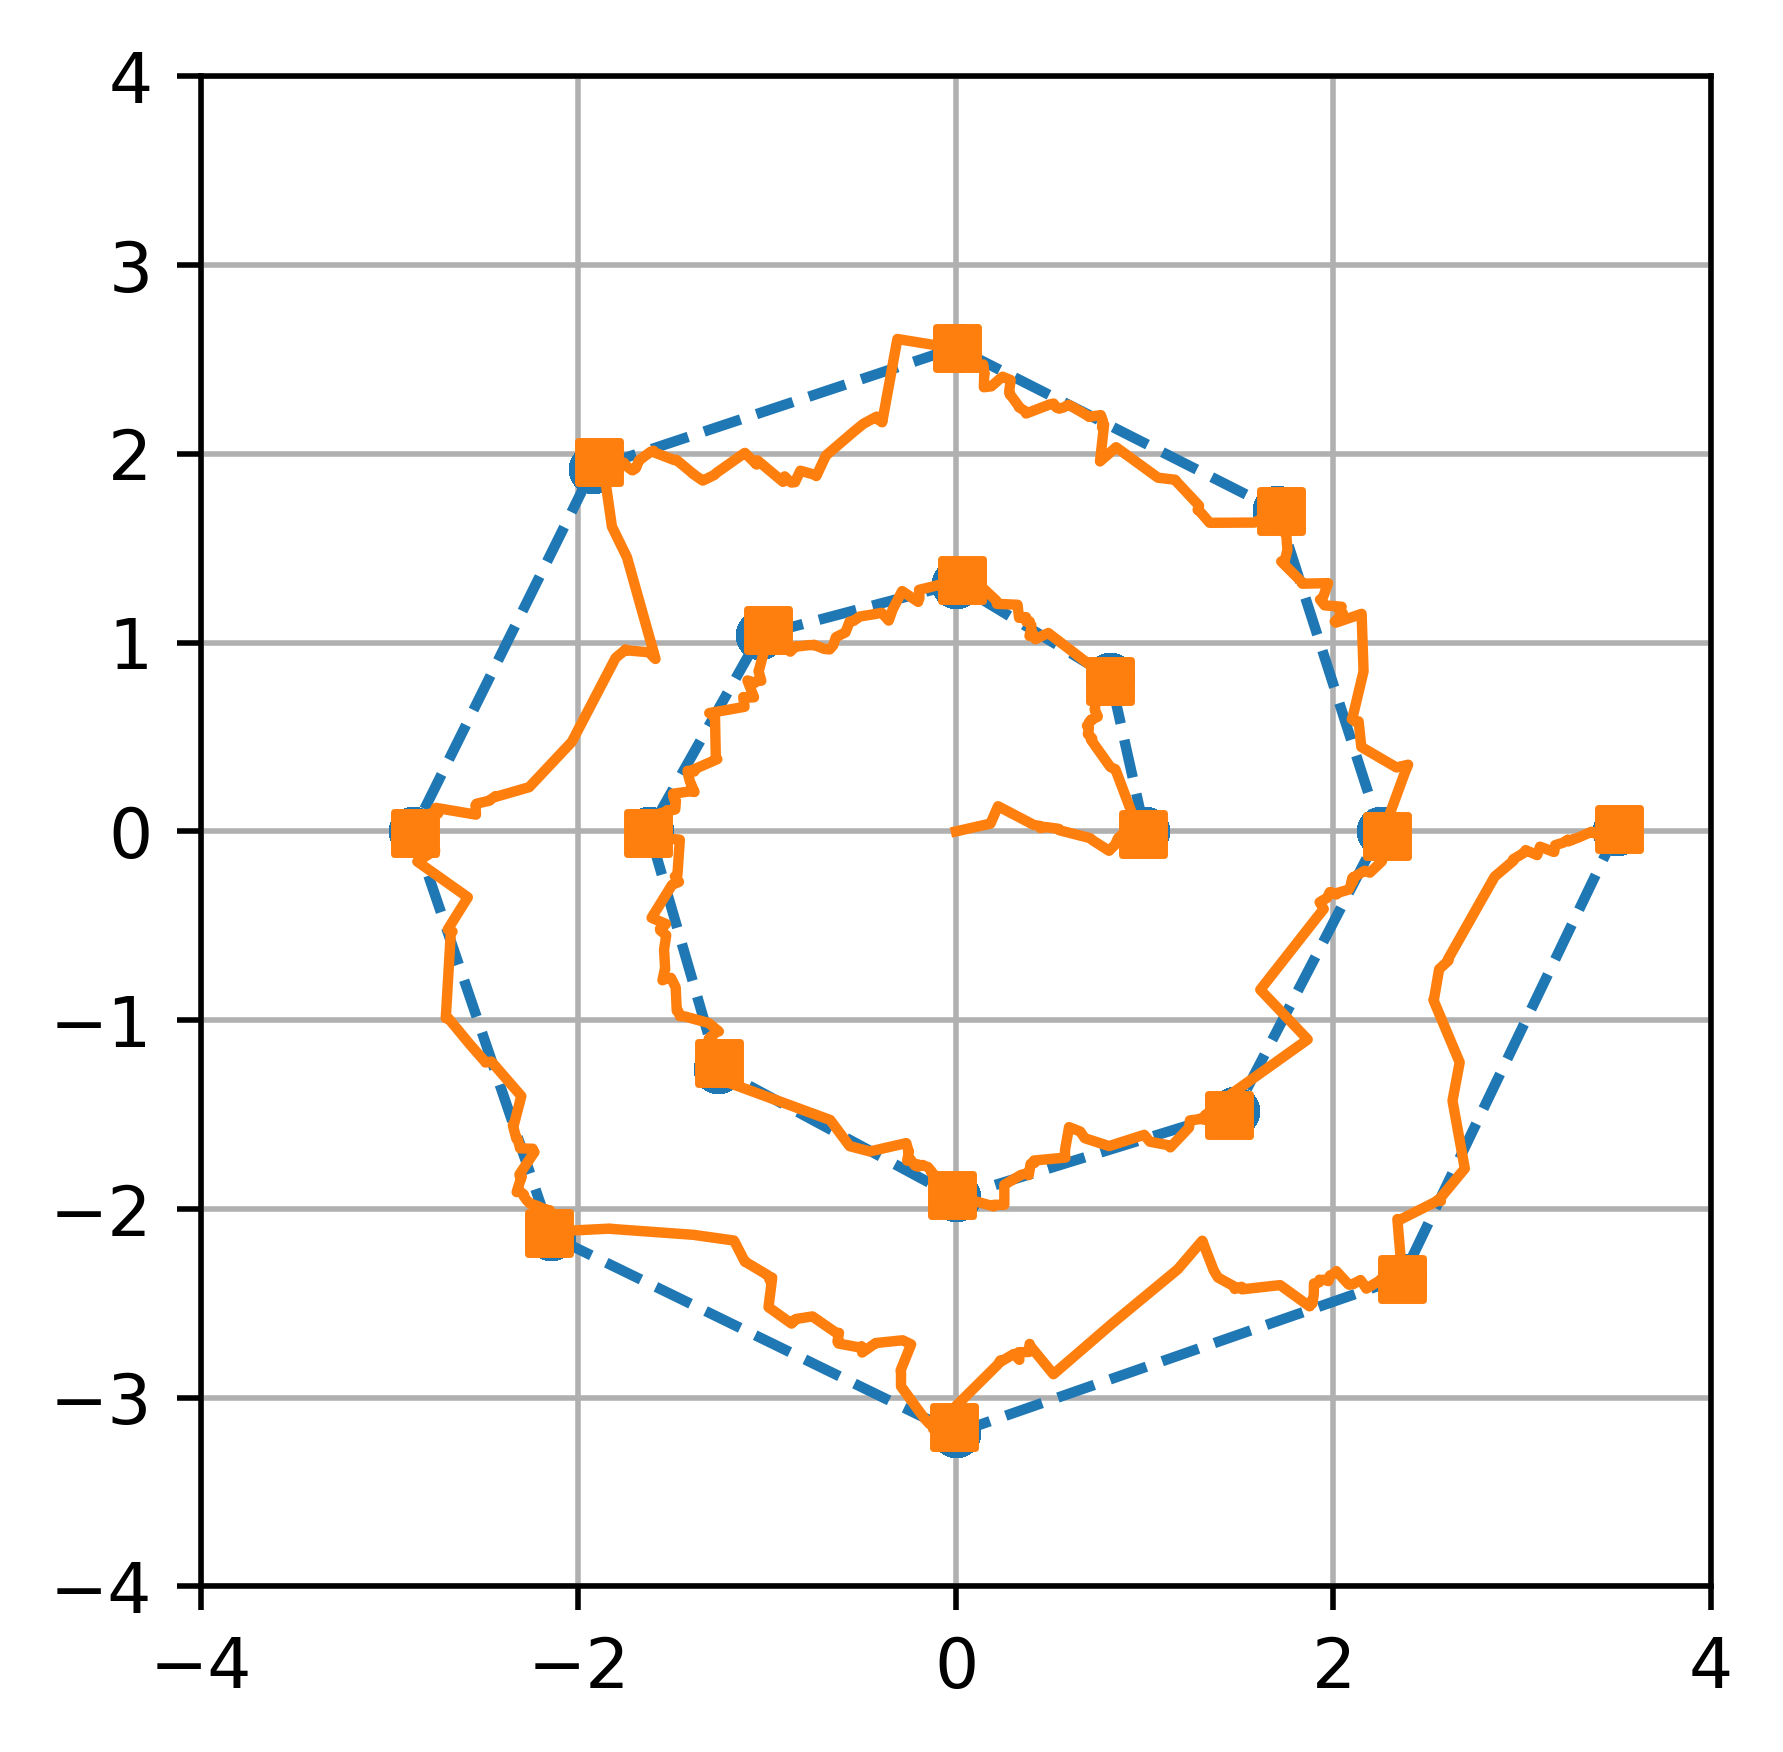

step_size: 0.1
regret: 220.76212


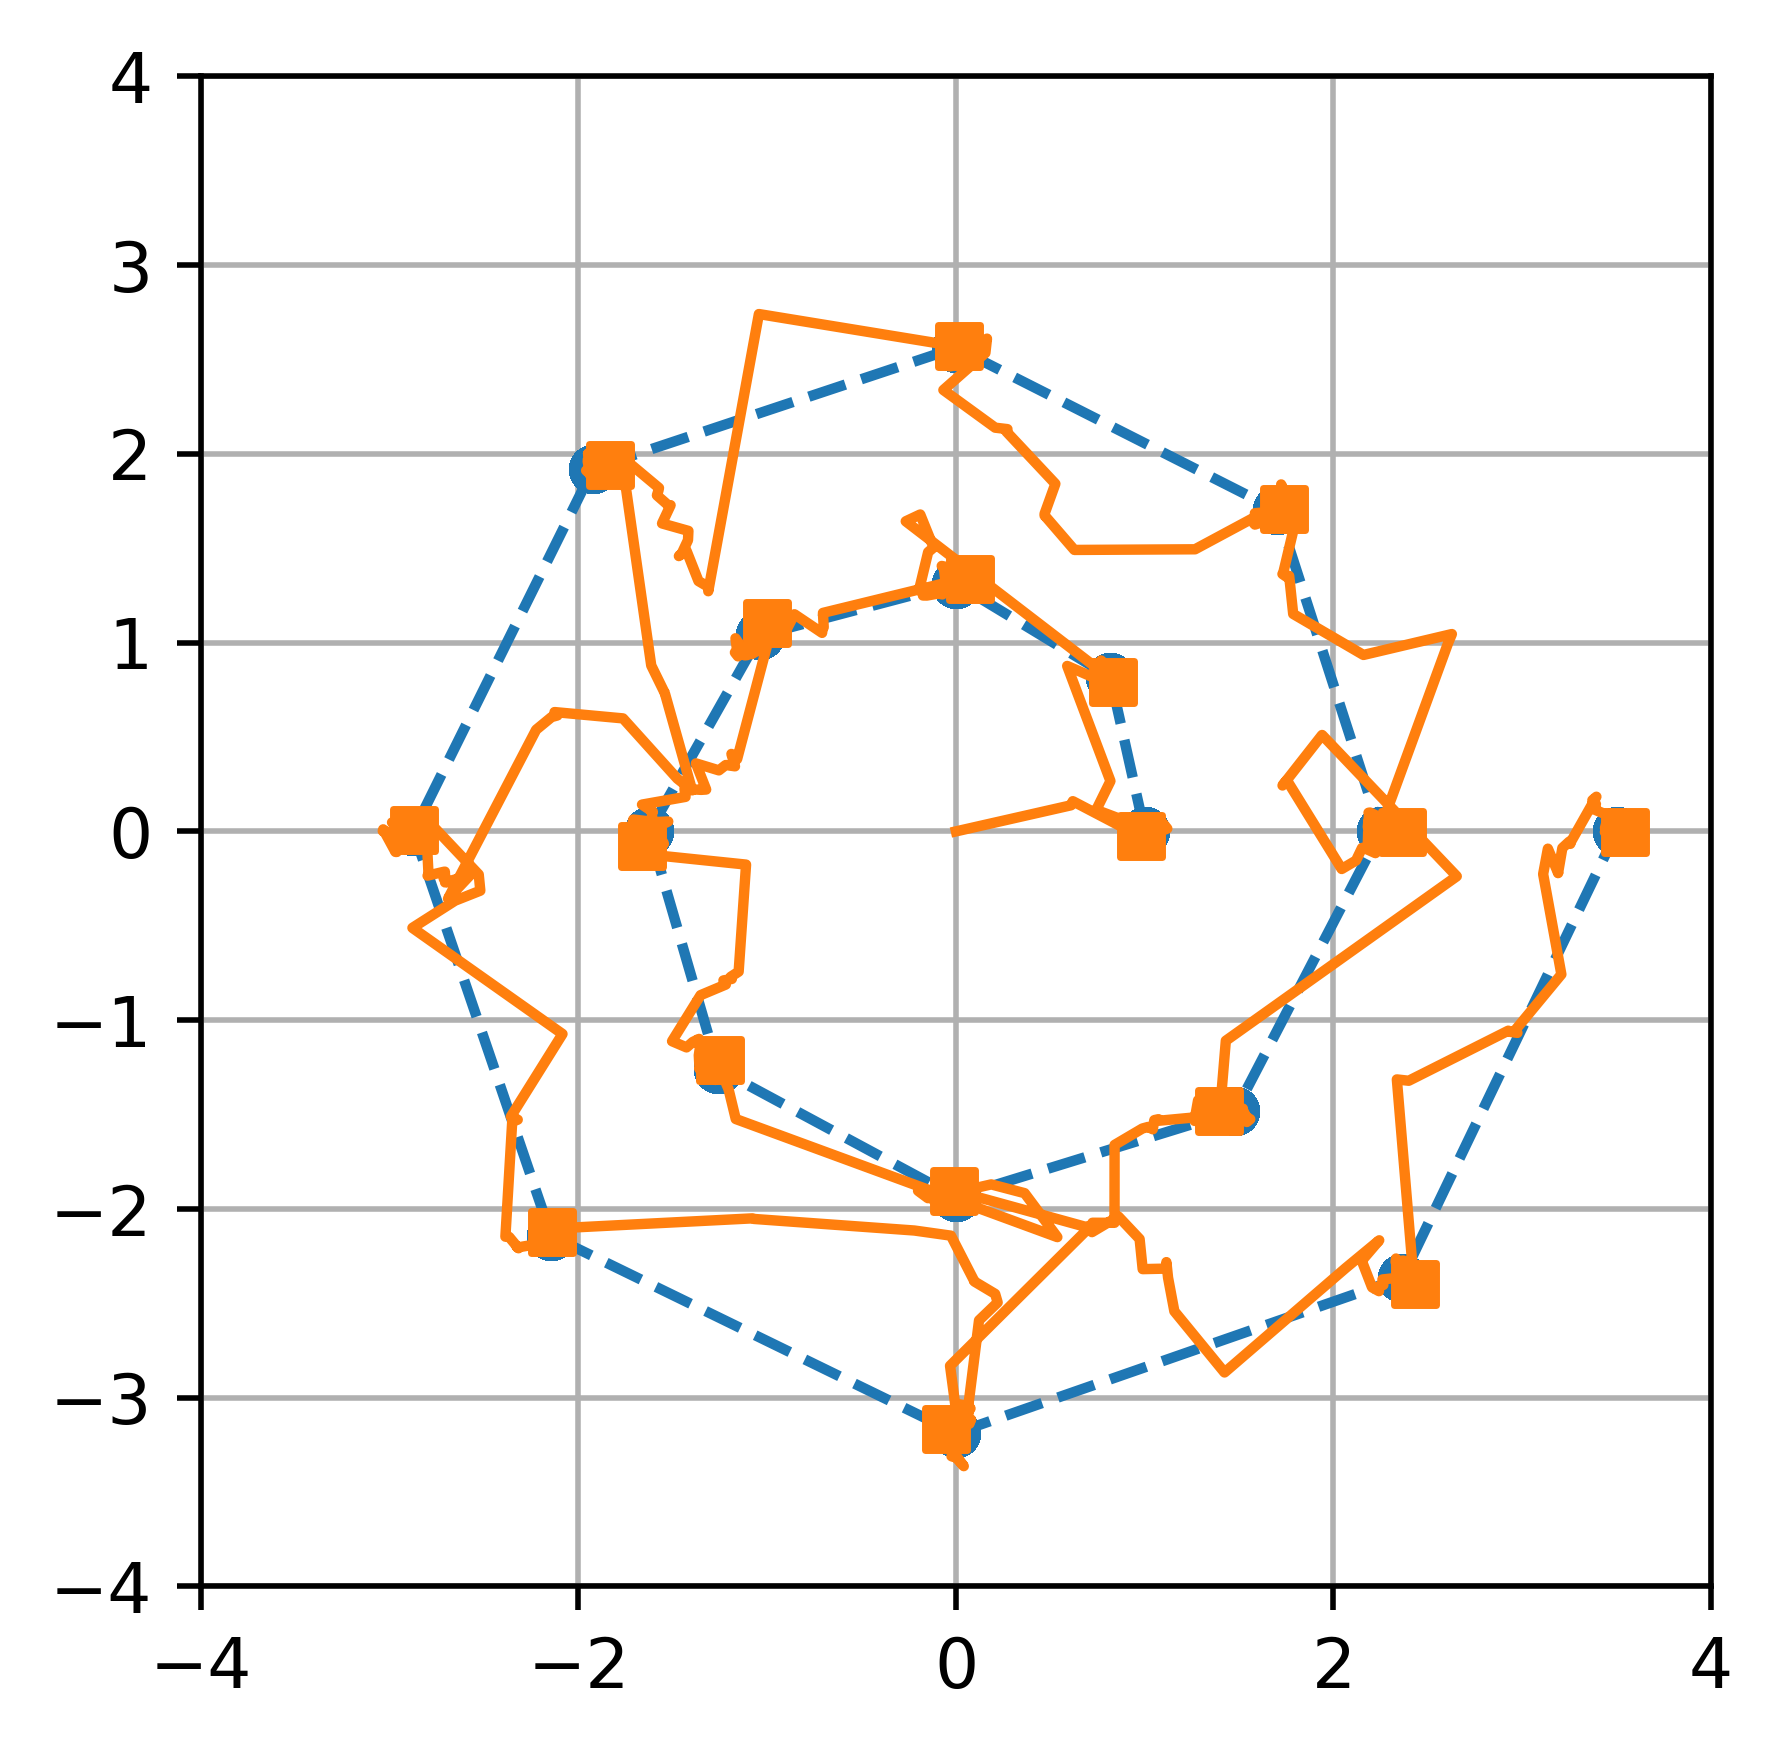

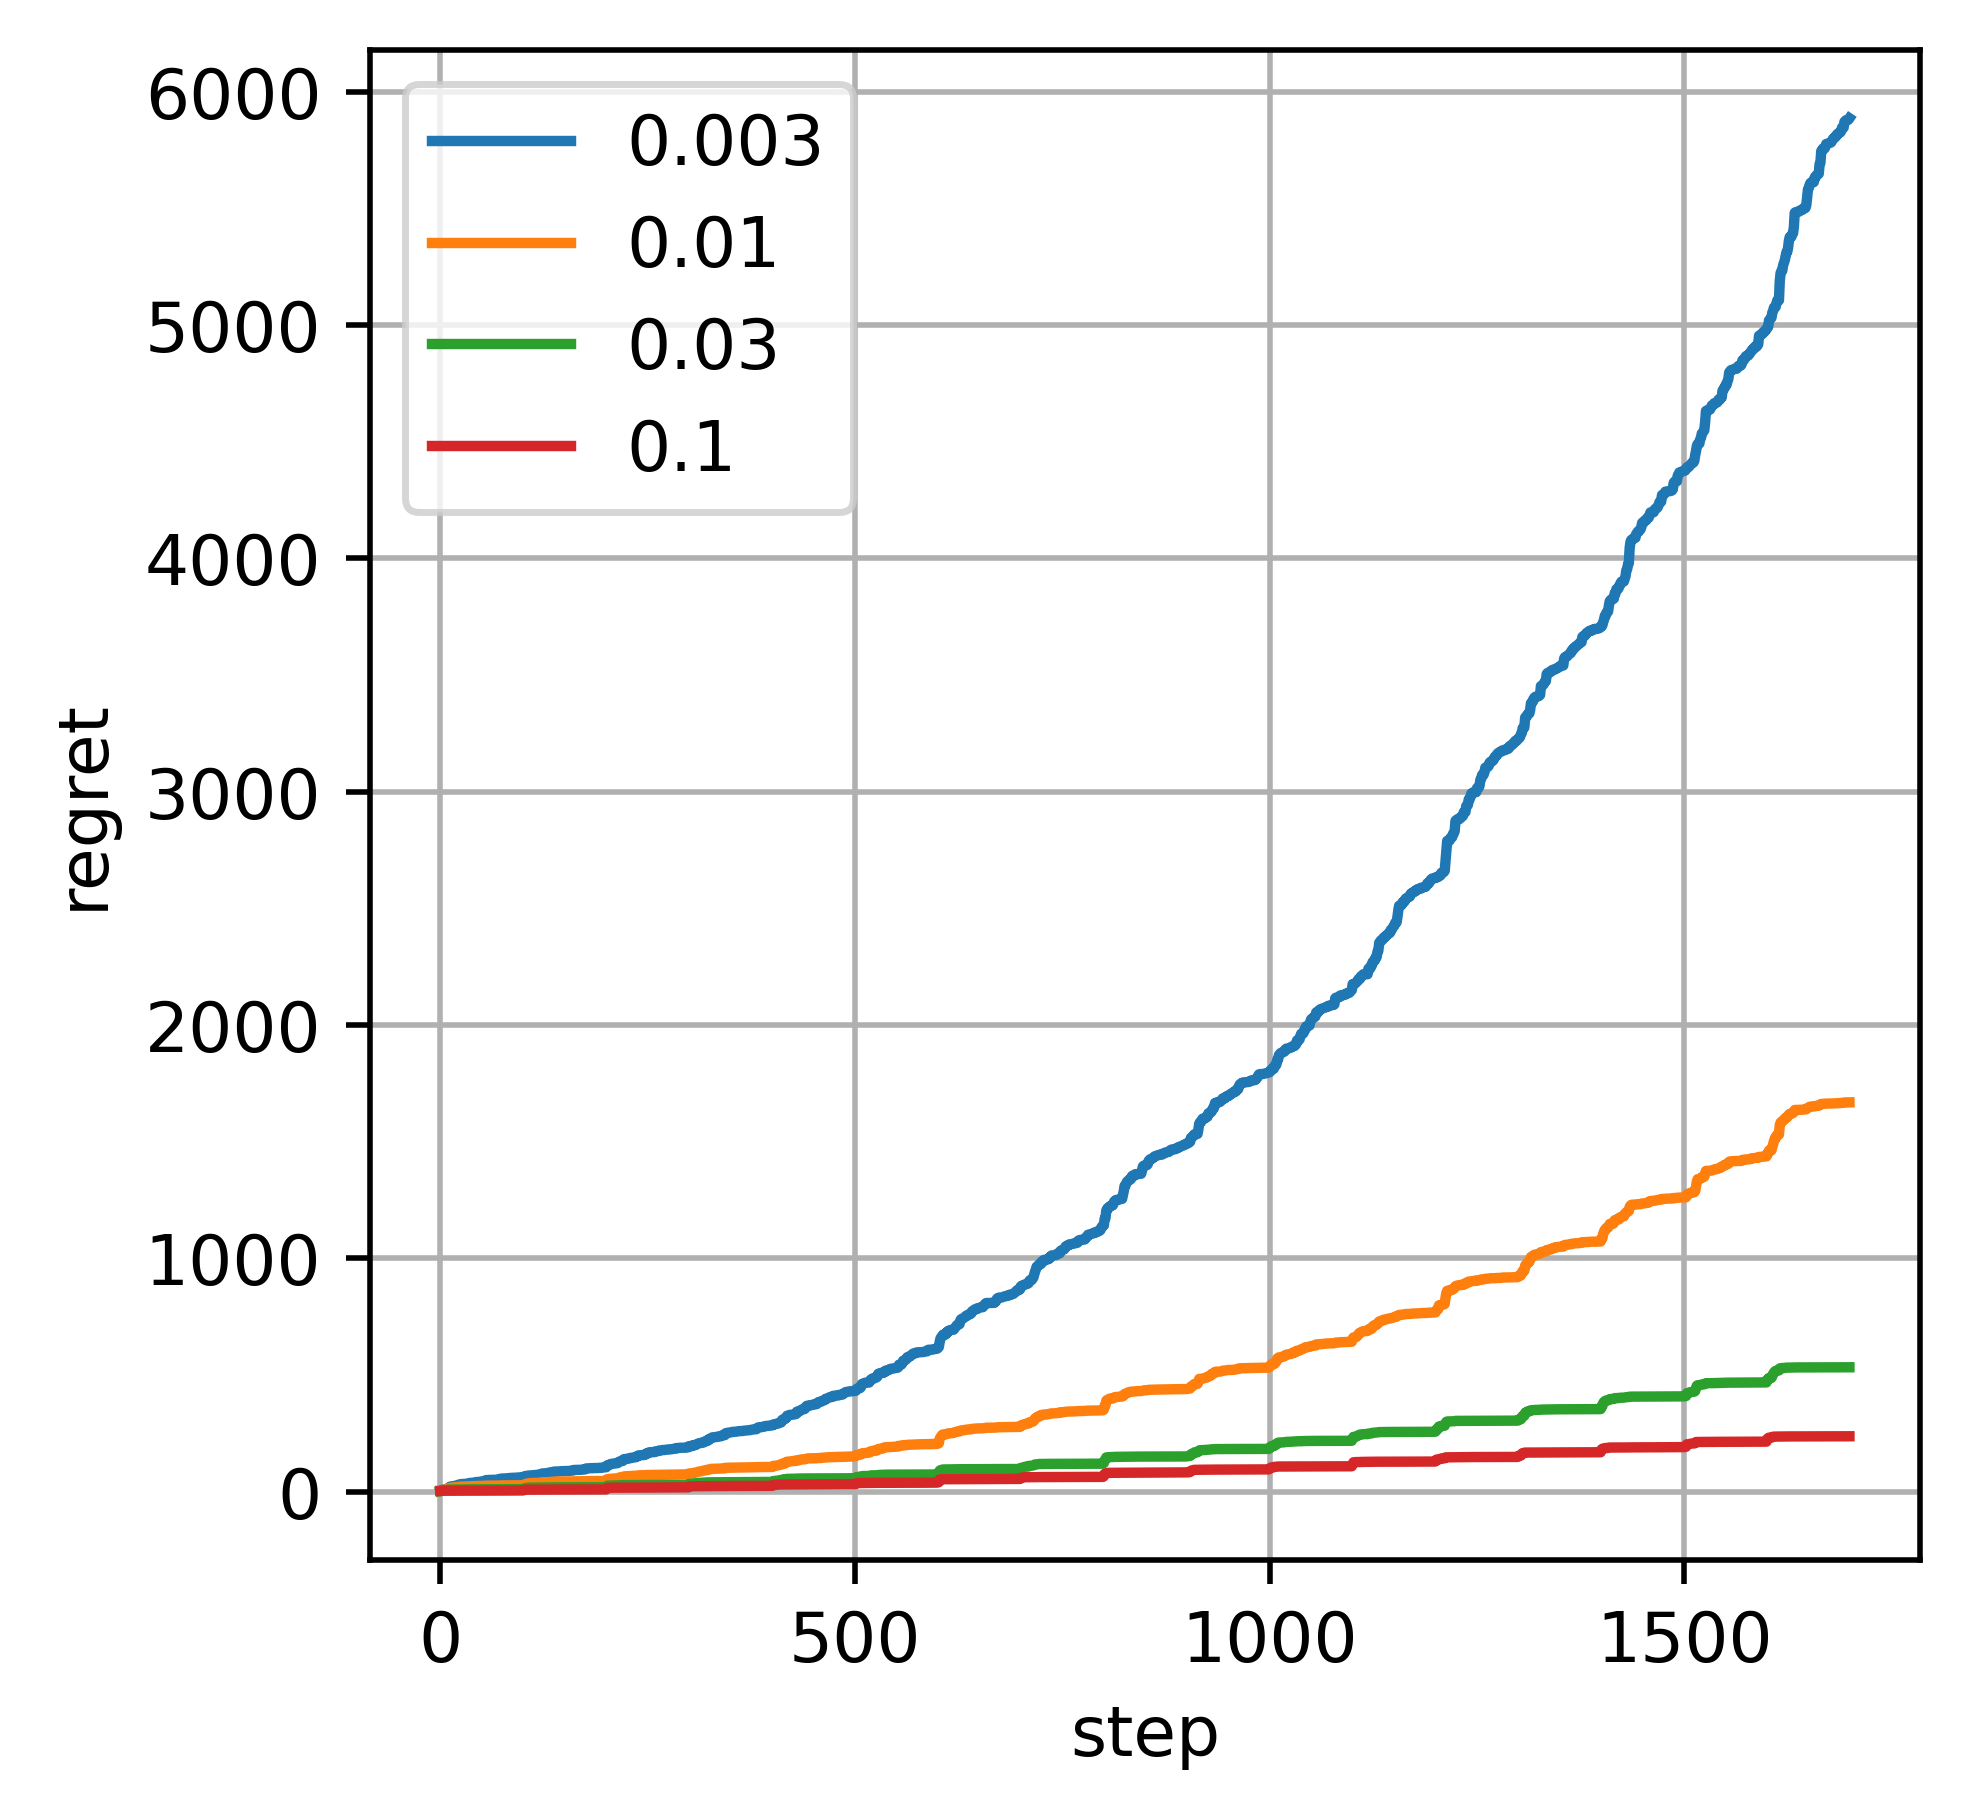

In [ ]:
#%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')

matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['savefig.dpi'] = 500

# Warm-up spiral experiments to illustrate the problem
BATCH_SIZE = 1
NUM_STEPS_PER_PHASE = 100
SIGMA_X = 1.0
SIGMA_NOISE = 0.1
MODEL_TYPE = 'linear_regression'

NUM_REVOLUTIONS = 2
NUM_STEPS = 16 + 1
DIMENSION = 2
angles = np.linspace(0, 2 * np.pi * NUM_REVOLUTIONS, num=NUM_STEPS)
radius = np.linspace(1, 3.5, num=NUM_STEPS)

# Construct theta_t* sequence
theta_stars = []
for t in range(len(angles)):
  angle = angles[t]
  coords = []
  for d in range(DIMENSION):
    phase = (d // 2) + 1
    if d % 2 == 0:
      coords.append(np.cos(phase * angle))
    else:
      coords.append(np.sin(phase * angle))
  row_vec = radius[t] * np.array(coords)
  theta_stars.append(row_vec)
theta_stars = np.array(theta_stars)
X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE)

STEP_SIZES = [0.003, 0.01, 0.03, 0.1]
#STEP_SIZES = [0.01, 0.03, 0.1, 0.3]
losses_hat = []
losses_opt = []
thetas_hat = []
thetas_opt = []
step_sizes = []
for step_size in STEP_SIZES:
  print('step_size:', step_size)
  learning_rate_schedule = {}
  learning_rate_schedule['constant'] = {'step_size': step_size}
  losses_hat_tmp, losses_opt_tmp, thetas_hat_tmp, thetas_opt_tmp, step_sizes_tmp = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)

  losses_hat.append(losses_hat_tmp)
  losses_opt.append(losses_opt_tmp)
  thetas_hat.append(thetas_hat_tmp)
  thetas_opt.append(thetas_opt_tmp)
  step_sizes.append(step_sizes_tmp)
  print('regret:', np.cumsum(np.array(losses_hat_tmp) - np.array(losses_opt_tmp))[-1])
  print()

#matplotlib.rcParams['figure.figsize'] = [4, 4]

for i in range(len(STEP_SIZES)):
  step_size = STEP_SIZES[i]
  print('step_size:', step_size)
  regret = np.cumsum(np.array(losses_hat[i]) - np.array(losses_opt[i]))
  print('regret:', regret[-1])

  plt.plot(thetas_opt[i][:,0], thetas_opt[i][:,1], linestyle='--', marker='o', label='theta_opt')
  plt.plot(thetas_hat[i][:,0], thetas_hat[i][:,1], linestyle='-', marker='None', label='theta_hat')
  # scatter plot phase-end points on top
  plt.scatter(thetas_hat[i][:,0][NUM_STEPS_PER_PHASE-1::NUM_STEPS_PER_PHASE], thetas_hat[i][:,1][NUM_STEPS_PER_PHASE-1::NUM_STEPS_PER_PHASE], marker='s', color='tab:orange', zorder=1000)
  plt.axis('scaled')
  plt.grid()
  plt.xlim([-4, 4])
  plt.ylim([-4, 4])
  plt.show()

# Plot regret curves
for i in range(len(STEP_SIZES)):
  #regret = np.cumsum(np.array(losses_hat[i]) - np.array(losses_opt[i]))
  regret = np.cumsum(np.array(losses_hat[i]))
  plt.plot(regret, label=STEP_SIZES[i])
plt.legend()
plt.xlabel('step')
plt.ylabel('regret')
plt.grid()
plt.show()

# Reset figsize
set_default_matplotlib_figsize()

# NUM_STEPS_PER_PHASE: 1
regret: 1.1845267


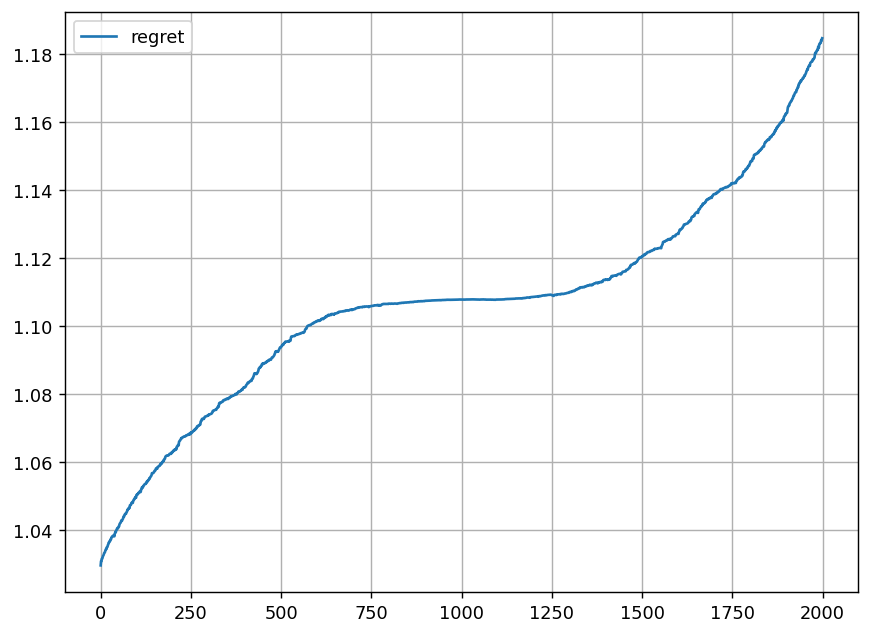

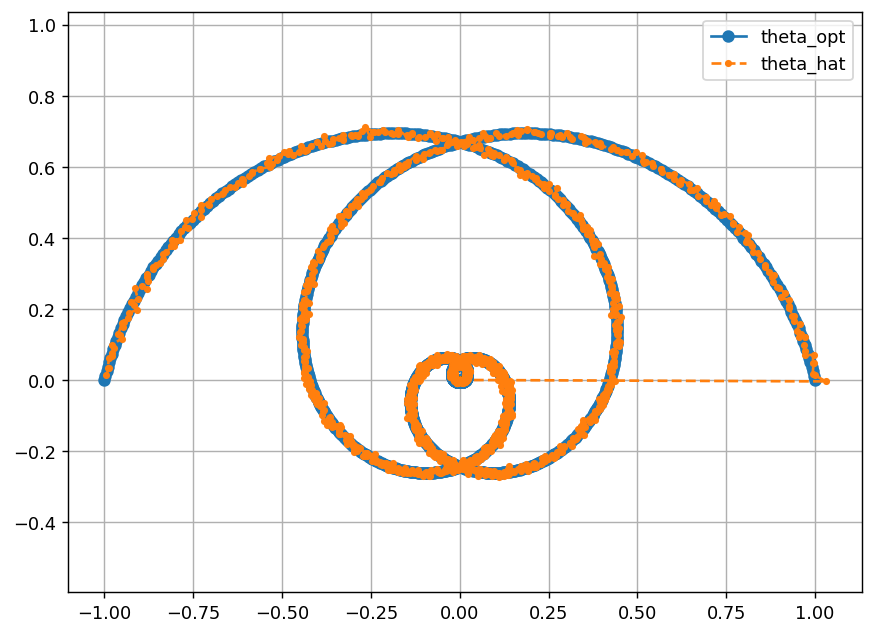

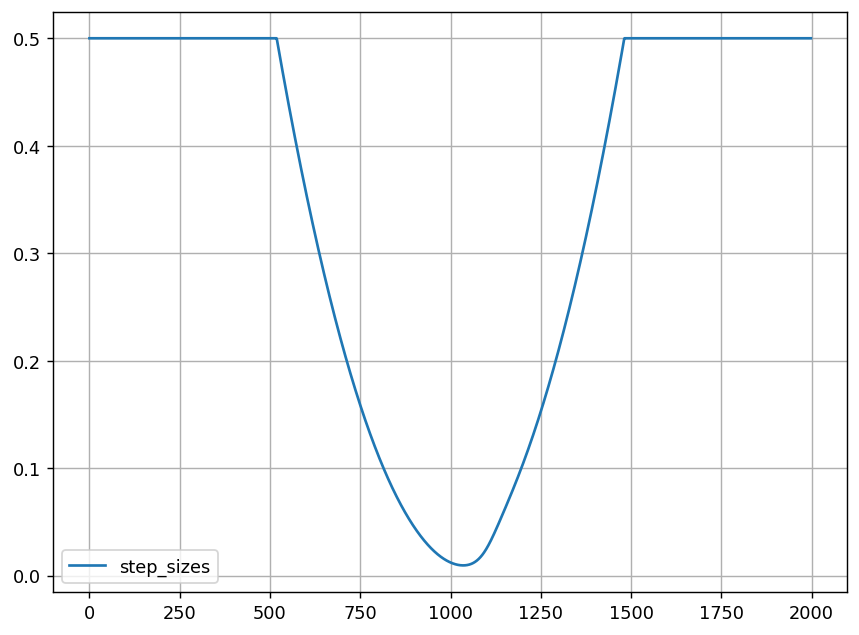

# NUM_STEPS_PER_PHASE: 4
regret: 1.3243772


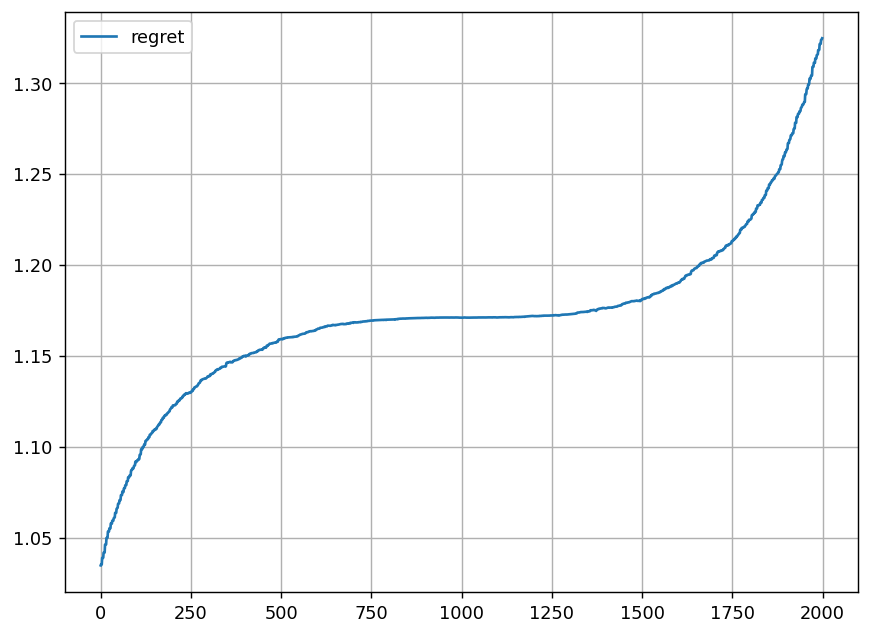

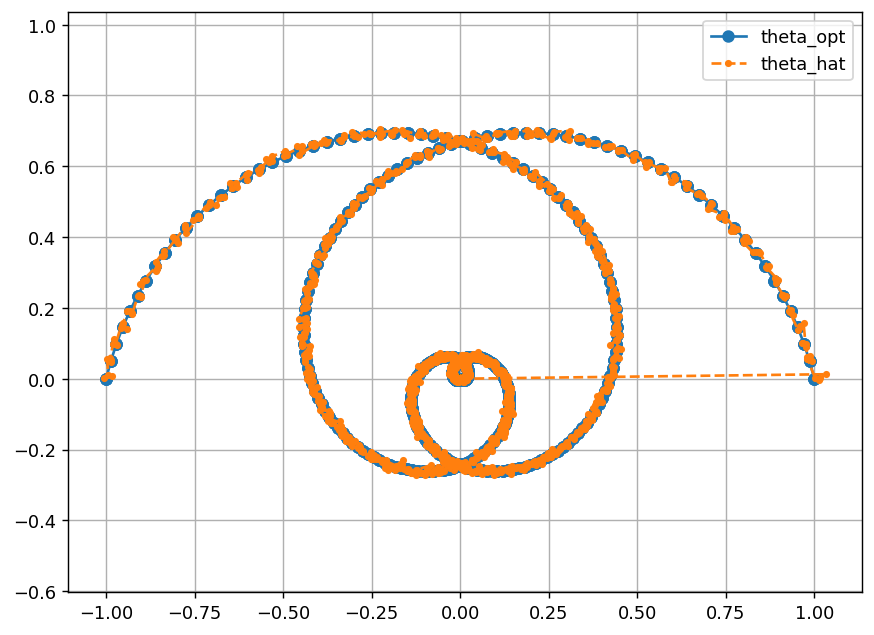

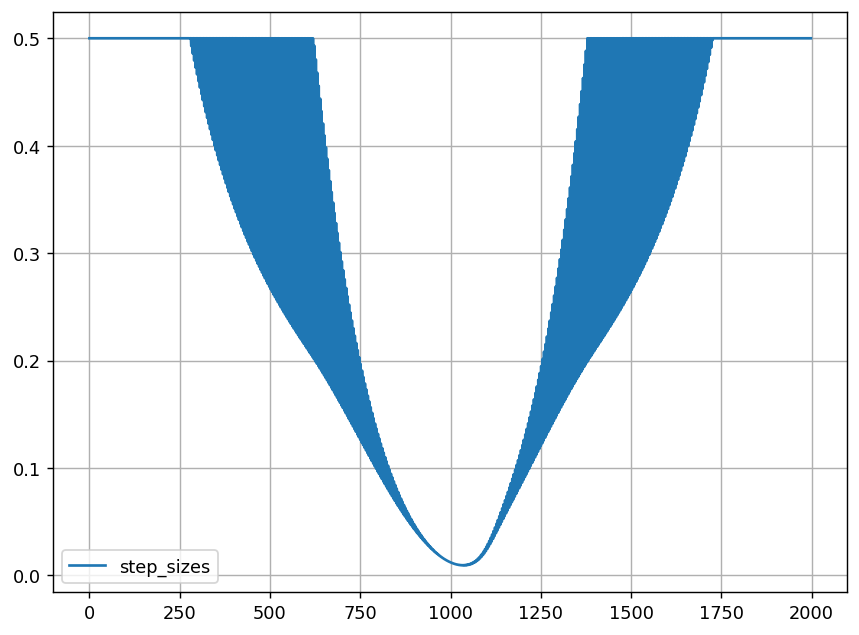

# NUM_STEPS_PER_PHASE: 16
regret: 1.8766189


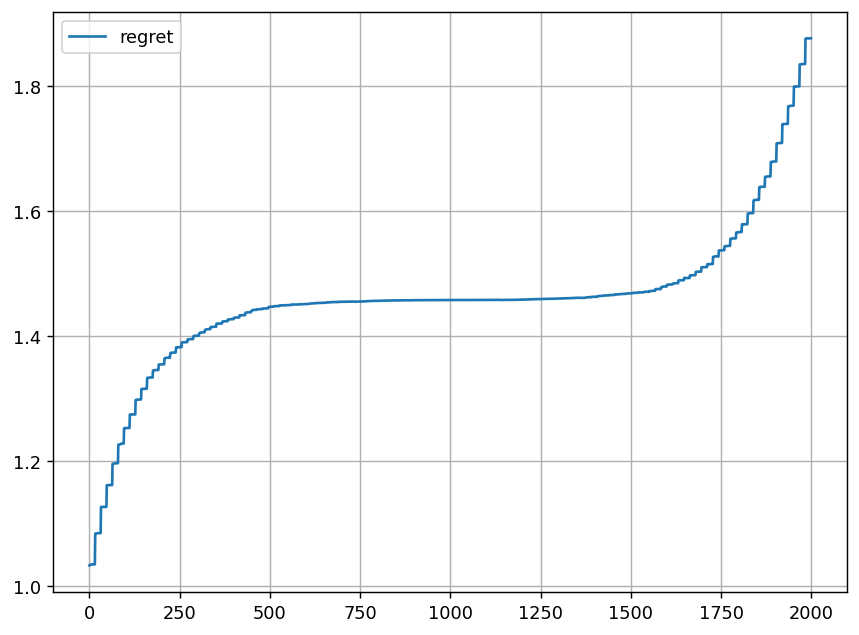

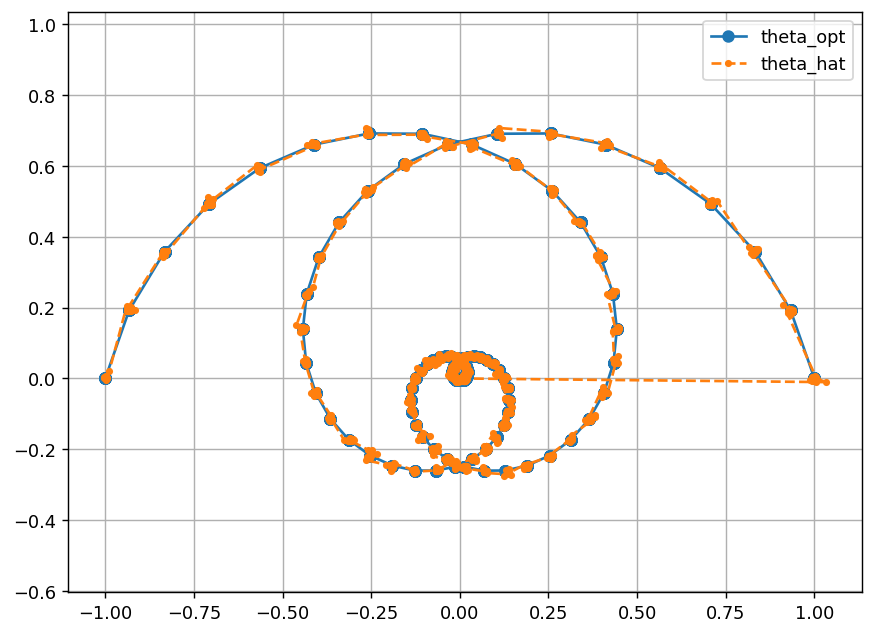

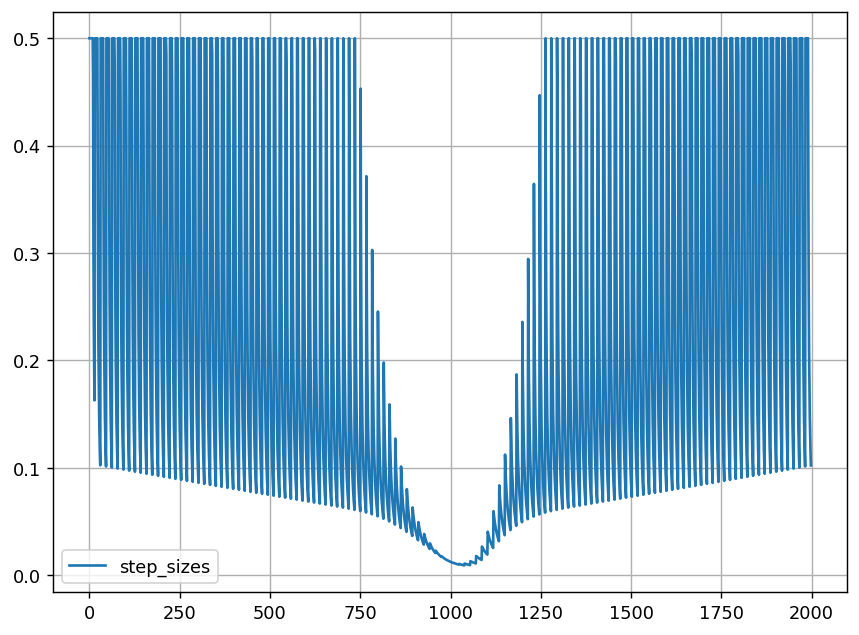

In [ ]:
# Linear regression (continuous vs discrete) -- this is solid for now

# Settings for camera-ready
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams['savefig.dpi'] = 128

NUM_STEPS_PER_PHASE_LIST = [1, 4, 16]
losses_hat_list = []
losses_opt_list = []
thetas_hat_list = []
thetas_opt_list = []
step_sizes_list = []

for NUM_STEPS_PER_PHASE in NUM_STEPS_PER_PHASE_LIST:
  print('# NUM_STEPS_PER_PHASE:', NUM_STEPS_PER_PHASE)
  BATCH_SIZE = 256
  SIGMA_X = 1.0
  SIGMA_NOISE = 0.1
  MODEL_TYPE = 'linear_regression'

  NUM_REVOLUTIONS = 4
  NUM_STEPS = 2000 // NUM_STEPS_PER_PHASE
  DIMENSION = 2
  angles = np.linspace(0, 2 * np.pi * NUM_REVOLUTIONS, num=NUM_STEPS)
  radius = np.linspace(1, -1, num=NUM_STEPS)
  radius = radius * radius * radius
  theta_stars = []
  for t in range(len(angles)):
    angle = angles[t]
    coords = []
    for d in range(DIMENSION):
      phase = (d // 2) + 1
      if d % 2 == 0:
        coords.append(np.cos(phase * angle))
      else:
        coords.append(np.sin(phase * angle))
    row_vec = radius[t] * np.array(coords)
    theta_stars.append(row_vec)
  theta_stars = np.array(theta_stars)
  X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE)

  # if DIMENSION == 2:
  #   plt.plot(thetas[:,0], thetas[:,1], marker='x', linestyle='-')
  #   plt.grid()
  #   plt.axis('equal')
  #   plt.show()
  # print(X.shape)
  # print(y.shape)

  # Run online learning algorithm
  learning_rate_schedule = {}
  learning_rate_schedule['our-algorithm-v3'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': 0.5}
  losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  print('regret:', np.cumsum(np.array(losses_hat) - np.array(losses_opt))[-1])
  losses_hat_list.append(losses_hat)
  losses_opt_list.append(losses_opt)
  thetas_opt_list.append(thetas_opt)
  thetas_hat_list.append(thetas_hat)
  step_sizes_list.append(step_sizes)

  regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  plt.plot(regret, label='regret')
  plt.legend()
  plt.grid()
  plt.show()

  plt.plot(thetas_opt[:,0], thetas_opt[:,1], linestyle='-', marker='o', label='theta_opt')
  plt.plot(thetas_hat[:,0], thetas_hat[:,1], linestyle='--', marker='.', label='theta_hat')
  plt.legend()
  plt.grid()
  plt.axis('equal')
  plt.show()

  plt.plot(step_sizes[:-1], label='step_sizes')
  plt.legend()
  plt.grid()
  plt.show()

# Reset figsize
set_default_matplotlib_figsize()

# DIMENSION: 2


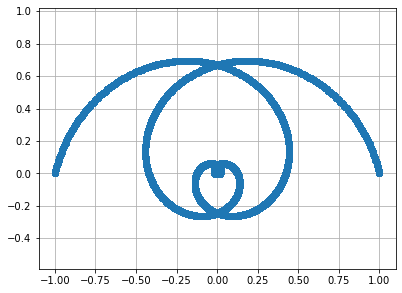

(512000, 2)
(512000,)
regret: 1.511874


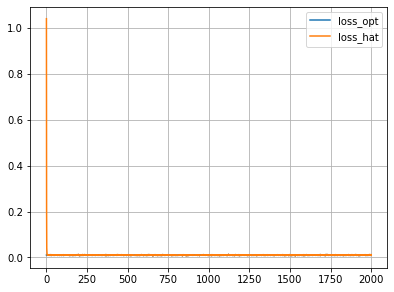

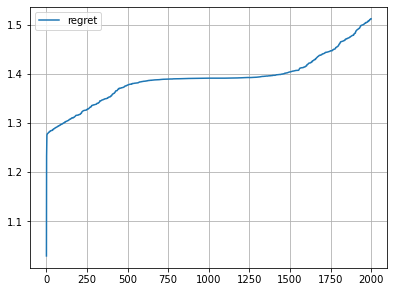

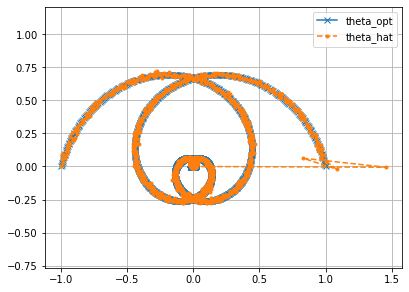

# DIMENSION: 4
(512000, 4)
(512000,)
regret: 2.5396602


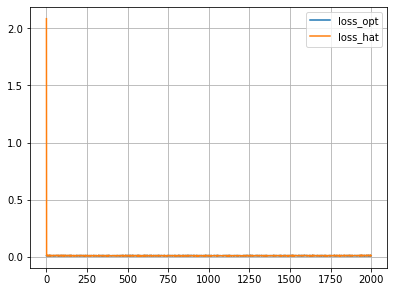

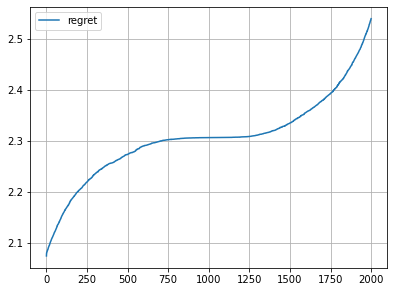

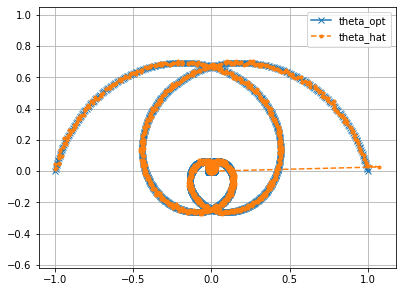

# DIMENSION: 8
(512000, 8)
(512000,)
regret: 7.347591


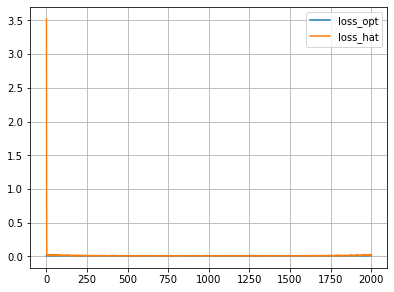

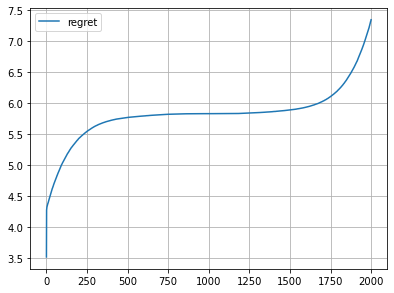

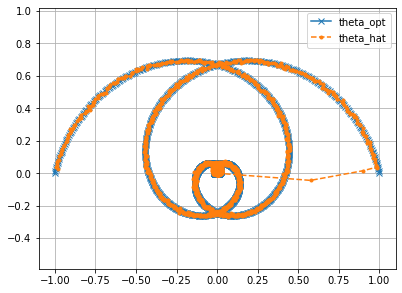

# DIMENSION: 32
(512000, 32)
(512000,)
regret: 513.84515


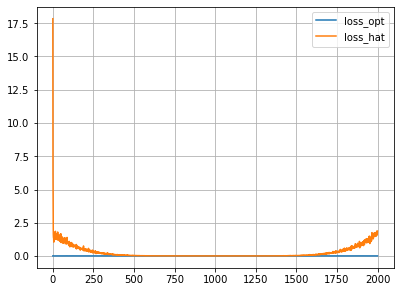

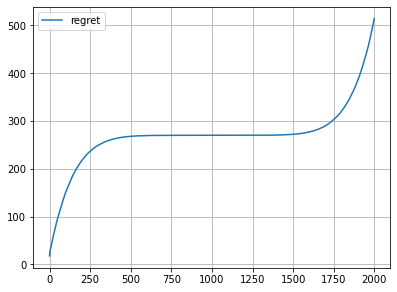

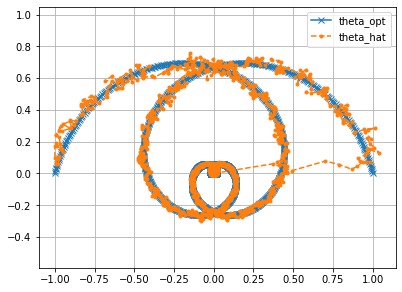

# DIMENSION: 64
(512000, 64)
(512000,)
regret: 4158.4546


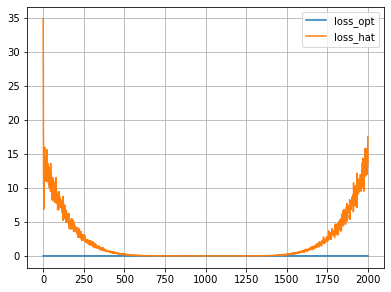

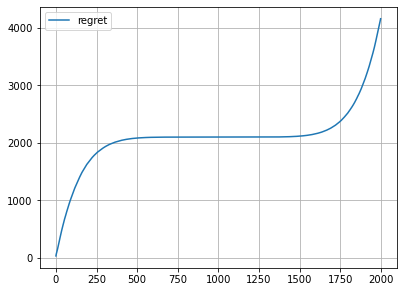

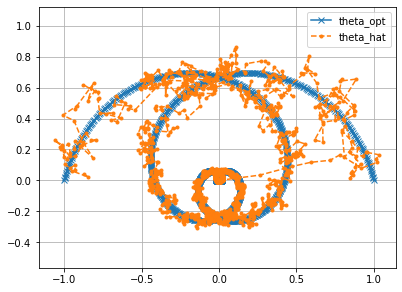

# DIMENSION: 128
(512000, 128)
(512000,)
regret: 15818.409


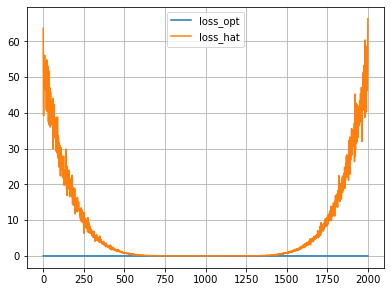

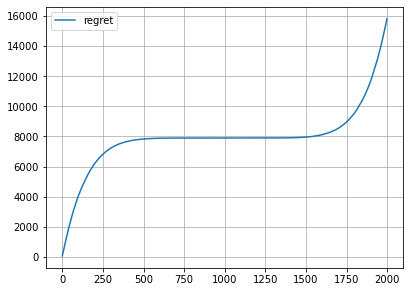

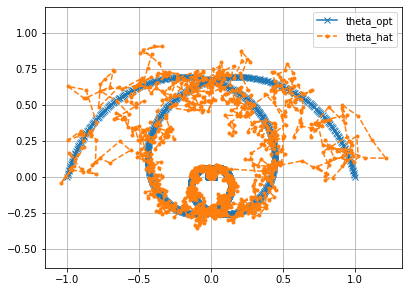

# DIMENSION: 256
(512000, 256)
(512000,)
regret: 39187.008


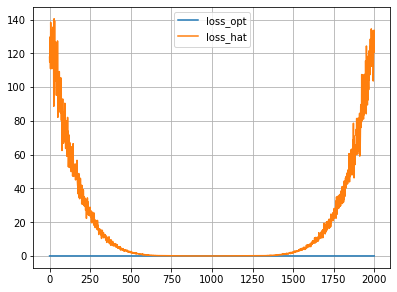

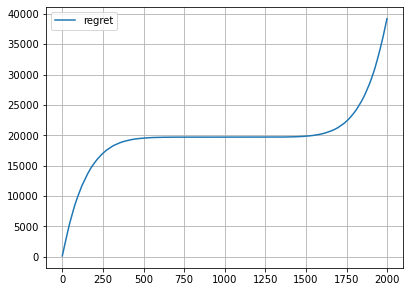

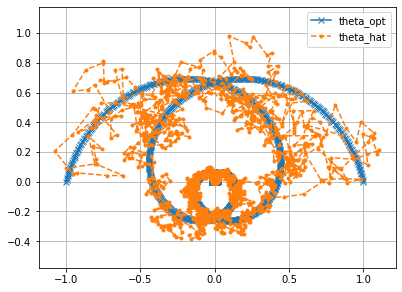

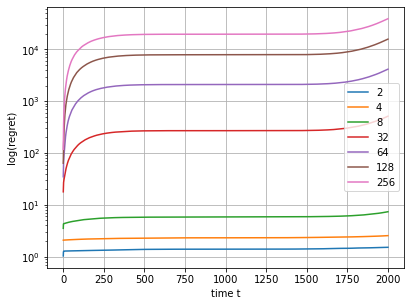

In [ ]:
# Sprial experiment (linear regression, dimension scaling)?
# v0: use max_step_size=0.5 for all dimensions
# v1: use max_step_size=1/dim for all dimensions
# v1: use max_step_size=1/sqrt(dim) for all dimensions

DIMENSION_LIST = [2, 4, 8, 32, 64, 128, 256]
losses_hat_list = []
losses_opt_list = []
thetas_hat_list = []
thetas_opt_list = []
step_sizes_list = []
regret_list = []

for DIMENSION in DIMENSION_LIST:
  print('# DIMENSION:', DIMENSION)
  BATCH_SIZE = 256
  NUM_STEPS_PER_PHASE = 1
  SIGMA_X = 1.0
  SIGMA_NOISE = 0.1
  MODEL_TYPE = 'linear_regression'

  NUM_REVOLUTIONS = 4
  NUM_STEPS = 2000
  angles = np.linspace(0, 2 * np.pi * NUM_REVOLUTIONS, num=NUM_STEPS)
  radius = np.linspace(1, -1, num=NUM_STEPS)
  radius = radius * radius * radius
  theta_stars = []
  for t in range(len(angles)):
    angle = angles[t]
    coords = []
    for d in range(DIMENSION):
      phase = (d // 2) + 1
      if d % 2 == 0:
        coords.append(np.cos(phase * angle))
      else:
        coords.append(np.sin(phase * angle))
    row_vec = radius[t] * np.array(coords)
    theta_stars.append(row_vec)
  theta_stars = np.array(theta_stars)
  X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE)

  if DIMENSION == 2:
    plt.plot(thetas[:,0], thetas[:,1], marker='o', linestyle='-')
    plt.grid()
    plt.axis('equal')
    plt.show()
  print(X.shape)
  print(y.shape)

  # Run online learning algorithm
  learning_rate_schedule = {}
  learning_rate_schedule['our-algorithm-v3'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': 1.0 / DIMENSION**0.5}
  losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  print('regret:', regret[-1])
  losses_hat_list.append(losses_hat)
  losses_opt_list.append(losses_opt)
  thetas_opt_list.append(thetas_opt)
  thetas_hat_list.append(thetas_hat)
  step_sizes_list.append(step_sizes)
  regret_list.append(regret)

  # Plot results
  plt.plot(losses_opt, label='loss_opt')
  plt.plot(losses_hat, label='loss_hat')
  plt.legend()
  plt.grid()
  plt.show()

  plt.plot(regret, label='regret')
  plt.legend()
  plt.grid()
  plt.show()

  if DIMENSION > 0:
    plt.plot(thetas_opt[:,0], thetas_opt[:,1], linestyle='-', marker='x', label='theta_opt')
    plt.plot(thetas_hat[:,0], thetas_hat[:,1], linestyle='--', marker='.', label='theta_hat')
    plt.legend()
    plt.grid()
    plt.axis('equal')
    plt.show()

  # plt.plot(step_sizes[:-1], label='step_sizes')
  # plt.legend()
  # plt.grid()
  # plt.show()

for i in range(len(DIMENSION_LIST)):
  DIMENSION = DIMENSION_LIST[i]
  regret = regret_list[i]
  plt.plot(regret, label=DIMENSION)
plt.grid()
plt.legend()
plt.yscale('log')
plt.ylabel('log(regret)')
plt.xlabel('time t')
plt.show()

# STEP_SIZE: 0.01
running algorithm const...
regret: 35024.645
running algorithm v3...
regret: 35024.645


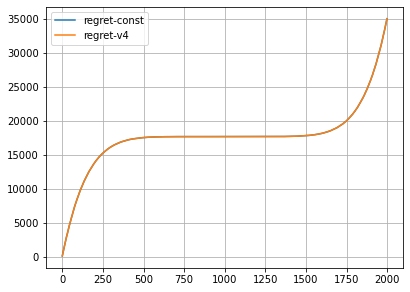

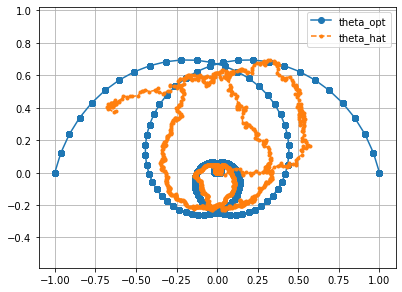

# STEP_SIZE: 0.03
running algorithm const...
regret: 30801.145
running algorithm v3...
regret: 30801.129


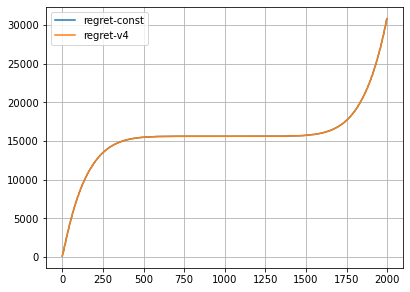

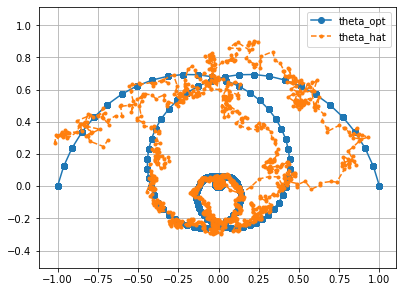

# STEP_SIZE: 0.1
running algorithm const...
regret: 21267.967
running algorithm v3...
regret: 21267.797


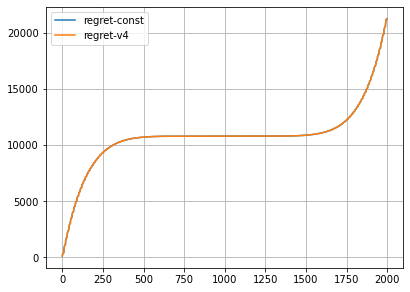

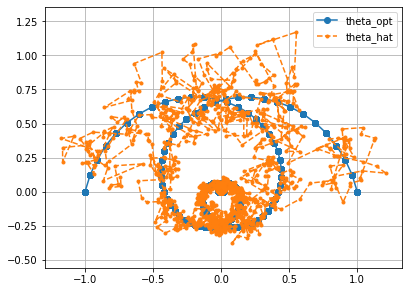

# STEP_SIZE: 0.3
running algorithm const...
regret: 16096.364
running algorithm v3...
regret: 16093.979


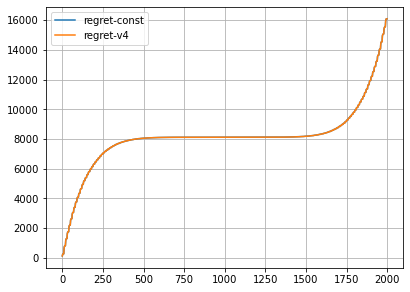

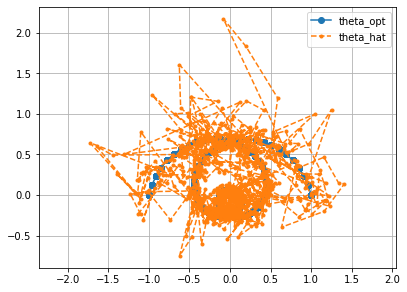

# final plot


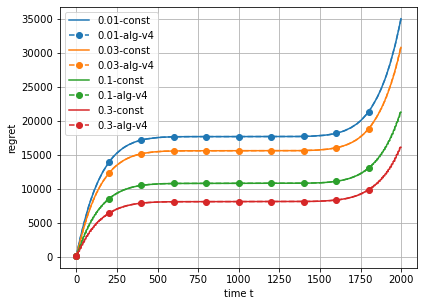

In [ ]:
# Sprial experiment (linear regression, step size scaling)?

STEP_SIZE_LIST = [0.01, 0.03, 0.1, 0.3]

losses_hat_list = []
losses_opt_list = []
thetas_hat_list = []
thetas_opt_list = []
step_sizes_list = []
regret_list = []

for STEP_SIZE in STEP_SIZE_LIST:
  print('# STEP_SIZE:', STEP_SIZE)
  BATCH_SIZE = 256
  DIMENSION = 256
  NUM_STEPS_PER_PHASE = 10
  SIGMA_X = 1.0
  SIGMA_NOISE = 0.1
  MODEL_TYPE = 'linear_regression'

  NUM_REVOLUTIONS = 4
  NUM_STEPS = 2000 // NUM_STEPS_PER_PHASE
  angles = np.linspace(0, 2 * np.pi * NUM_REVOLUTIONS, num=NUM_STEPS)
  radius = np.linspace(1, -1, num=NUM_STEPS)
  radius = radius * radius * radius
  theta_stars = []
  for t in range(len(angles)):
    angle = angles[t]
    coords = []
    for d in range(DIMENSION):
      phase = (d // 2) + 1
      if d % 2 == 0:
        coords.append(np.cos(phase * angle))
      else:
        coords.append(np.sin(phase * angle))
    row_vec = radius[t] * np.array(coords)
    theta_stars.append(row_vec)
  theta_stars = np.array(theta_stars)
  X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE)

  # Run online learning algorithm (const)
  learning_rate_schedule = {}
  learning_rate_schedule['constant'] = {'step_size': STEP_SIZE}
  print('running algorithm const...')
  losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  print('regret:', regret[-1])
  losses_hat_list.append(losses_hat)
  losses_opt_list.append(losses_opt)
  thetas_opt_list.append(thetas_opt)
  thetas_hat_list.append(thetas_hat)
  step_sizes_list.append(step_sizes)
  regret_list.append(regret)

  learning_rate_schedule = {}
  learning_rate_schedule['our-algorithm-v3'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': STEP_SIZE}
  print('running algorithm v3...')
  losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  print('regret:', regret[-1])
  losses_hat_list.append(losses_hat)
  losses_opt_list.append(losses_opt)
  thetas_opt_list.append(thetas_opt)
  thetas_hat_list.append(thetas_hat)
  step_sizes_list.append(step_sizes)
  regret_list.append(regret)

  plt.plot(regret_list[-2], label='regret-const')
  plt.plot(regret_list[-1], label='regret-v4')
  plt.legend()
  plt.grid()
  plt.show()

  if DIMENSION > 0:
    plt.plot(thetas_opt[:,0], thetas_opt[:,1], linestyle='-', marker='o', label='theta_opt')
    plt.plot(thetas_hat[:,0], thetas_hat[:,1], linestyle='--', marker='.', label='theta_hat')
    plt.legend()
    plt.grid()
    plt.axis('equal')
    plt.show()


print('# final plot')
colors = list(matplotlib.colors.TABLEAU_COLORS.keys()) + list(matplotlib.colors.TABLEAU_COLORS.keys())
for i in range(len(STEP_SIZE_LIST)):
  STEP_SIZE = STEP_SIZE_LIST[i]
  const_idx = 2*i
  alg_v3_idx = 2*i + 1
  plt.plot(regret_list[const_idx], linestyle='-', label=str(STEP_SIZE) + '-const', c=colors[i])
  plt.plot(regret_list[alg_v3_idx], linestyle='--', marker='o', markevery=(NUM_STEPS * NUM_STEPS_PER_PHASE)//10, label=str(STEP_SIZE) + '-alg-v4', c=colors[i])

plt.grid()
plt.legend()
#plt.yscale('log')
#plt.ylabel('log(regret)')
plt.ylabel('regret')
plt.xlabel('time t')
plt.show()

# DIMENSION: 2
running algorithm v3...
regret: 1.9411007


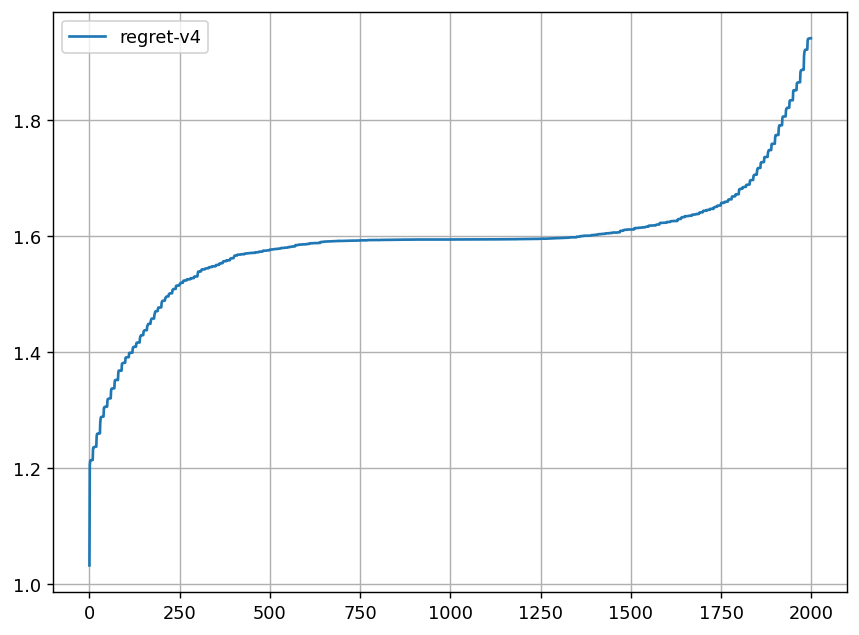

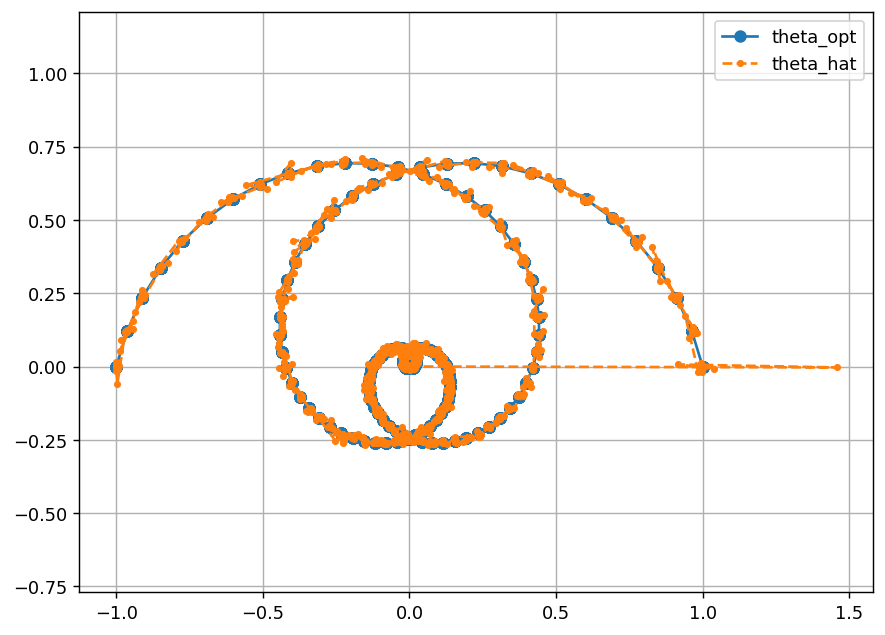

# DIMENSION: 8
running algorithm v3...
regret: 19.42145


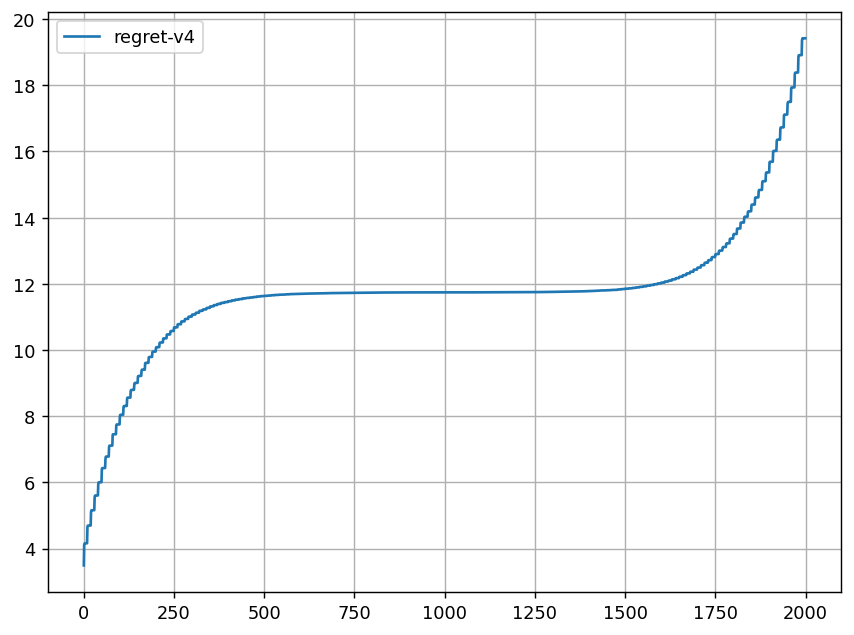

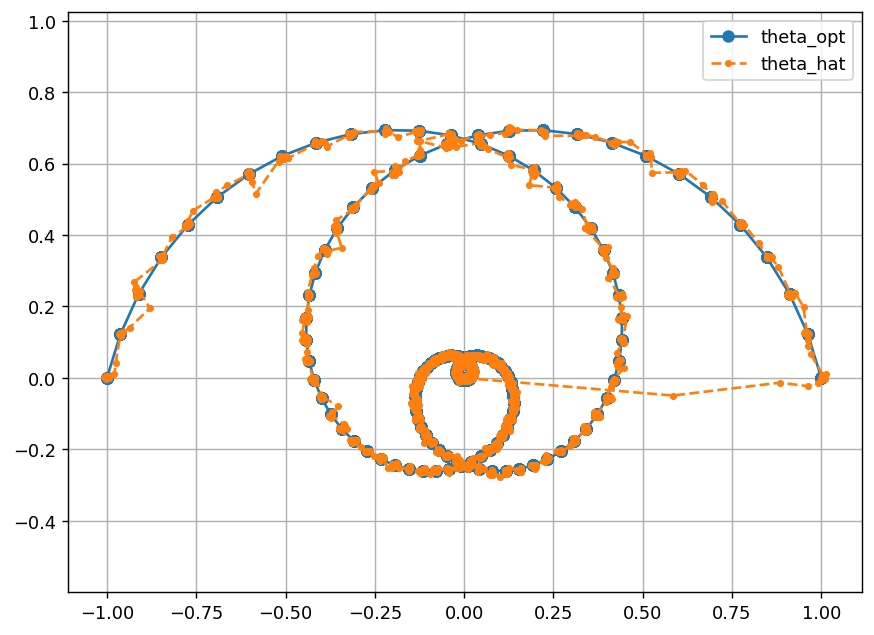

# DIMENSION: 32
running algorithm v3...
regret: 995.9837


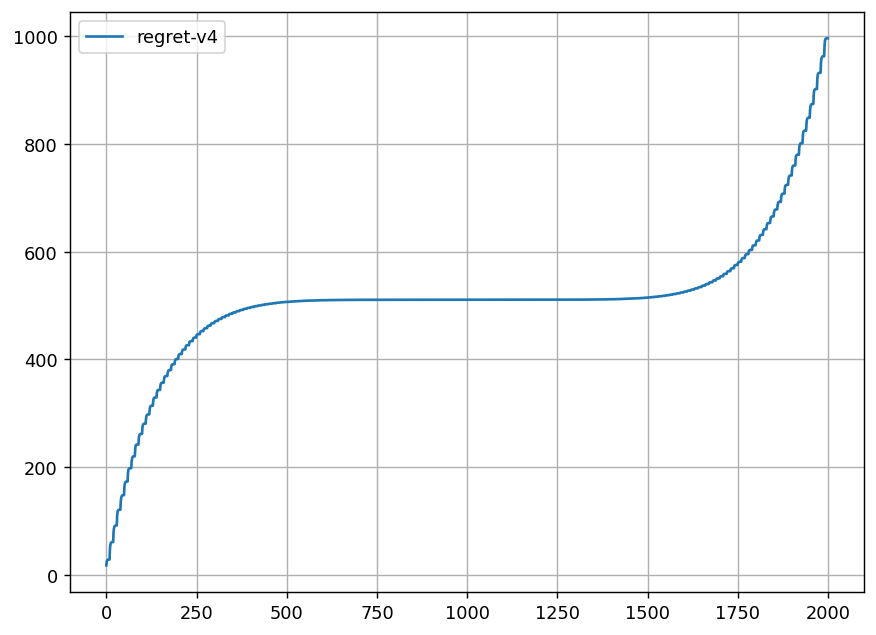

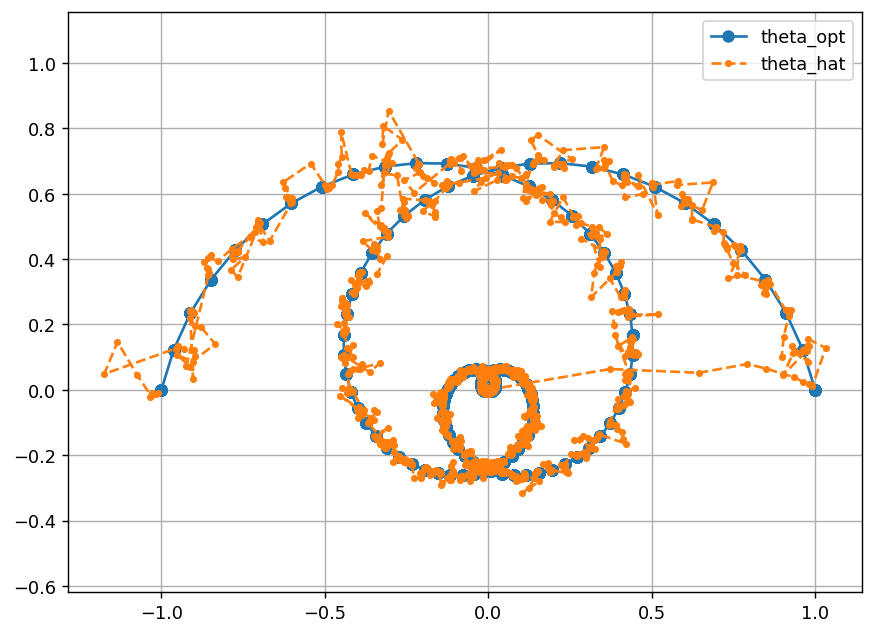

# DIMENSION: 128
running algorithm v3...
regret: 9459.465


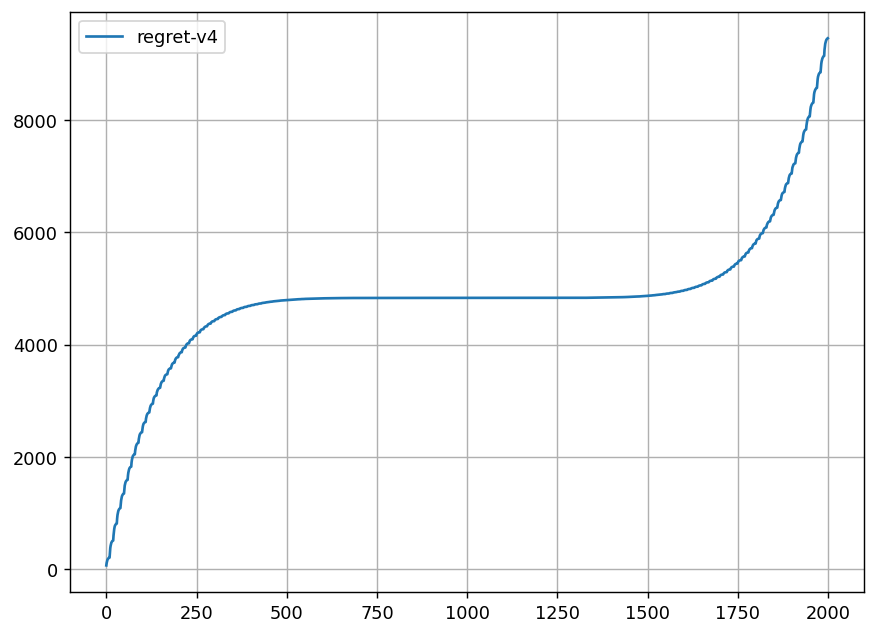

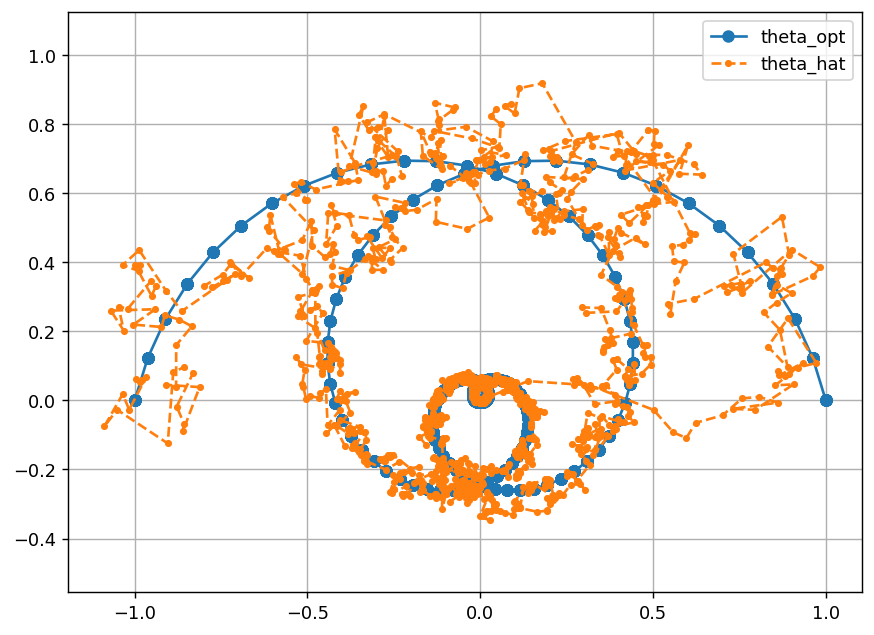

# DIMENSION: 512
running algorithm v3...
regret: 57562.855


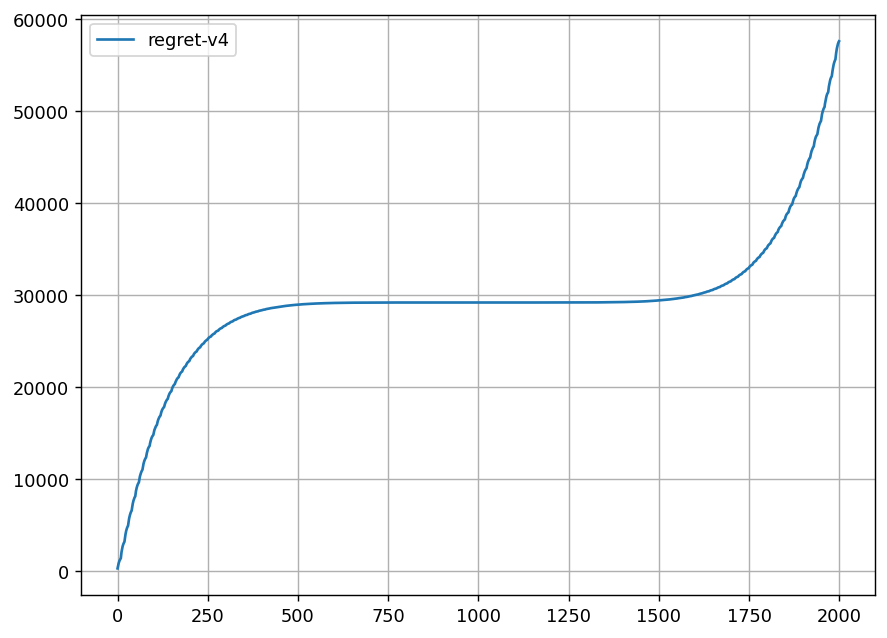

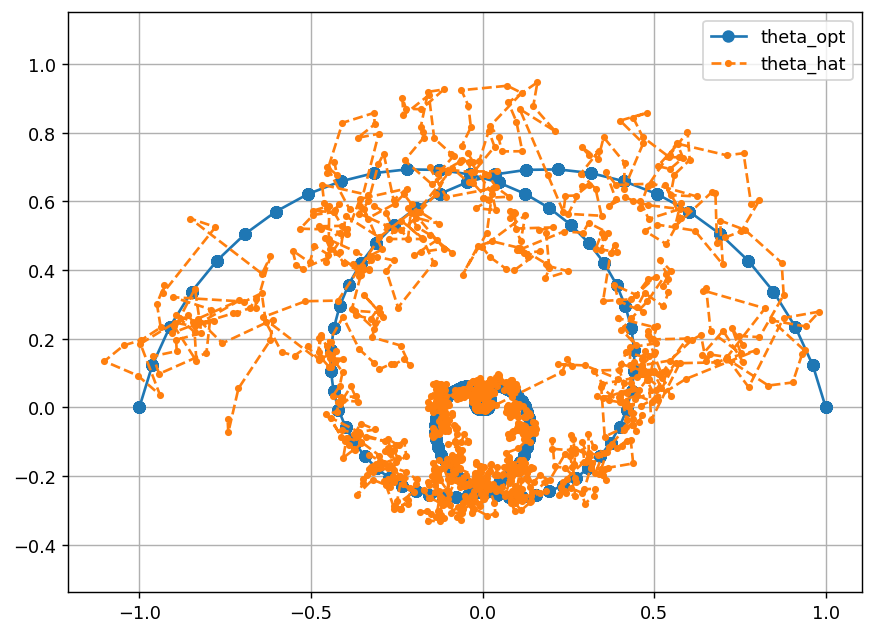

# final plot


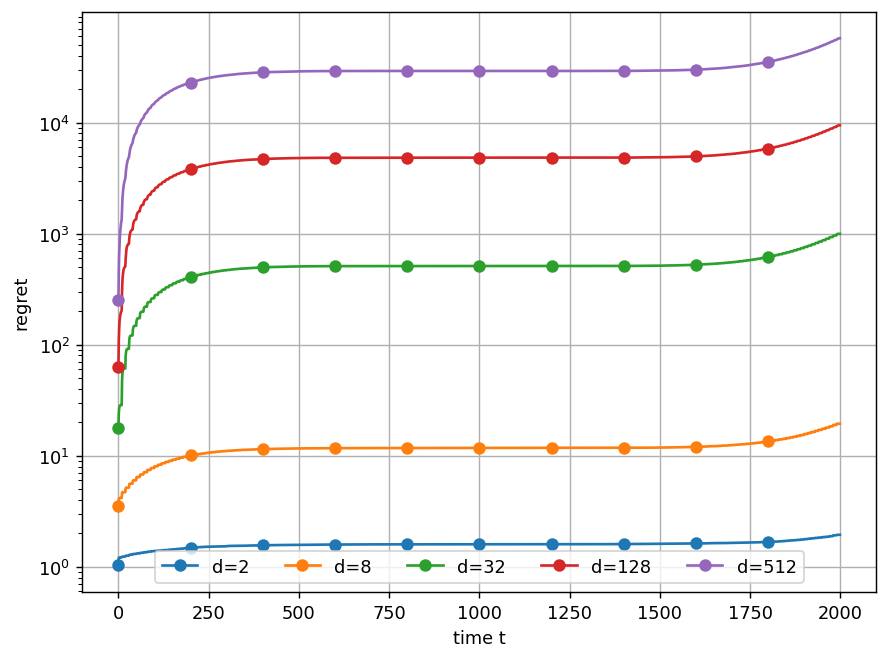

In [ ]:
# Sprial experiment (linear regression, dimension scaling)

# Settings for camera-ready
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams['savefig.dpi'] = 128

#DIMENSION_LIST = [2, 8]
DIMENSION_LIST = [2, 8, 32, 128, 512]

losses_hat_list = []
losses_opt_list = []
thetas_hat_list = []
thetas_opt_list = []
step_sizes_list = []
regret_list = []

for DIMENSION in DIMENSION_LIST:
  print('# DIMENSION:', DIMENSION)
  BATCH_SIZE = 256
  NUM_STEPS_PER_PHASE = 10
  SIGMA_X = 1.0
  SIGMA_NOISE = 0.1
  MODEL_TYPE = 'linear_regression'
  STEP_SIZE = 0.5

  NUM_REVOLUTIONS = 4
  NUM_STEPS = 2000 // NUM_STEPS_PER_PHASE
  angles = np.linspace(0, 2 * np.pi * NUM_REVOLUTIONS, num=NUM_STEPS)
  radius = np.linspace(1, -1, num=NUM_STEPS)
  radius = radius * radius * radius
  theta_stars = []
  for t in range(len(angles)):
    angle = angles[t]
    coords = []
    for d in range(DIMENSION):
      phase = (d // 2) + 1
      if d % 2 == 0:
        coords.append(np.cos(phase * angle))
      else:
        coords.append(np.sin(phase * angle))
    row_vec = radius[t] * np.array(coords)
    theta_stars.append(row_vec)
  theta_stars = np.array(theta_stars)
  X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE)

  # # Run online learning algorithm (const)
  # learning_rate_schedule = {}
  # learning_rate_schedule['constant'] = {'step_size': STEP_SIZE}
  # print('running algorithm const...')
  # losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  # regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  # print('regret:', regret[-1])
  # losses_hat_list.append(losses_hat)
  # losses_opt_list.append(losses_opt)
  # thetas_opt_list.append(thetas_opt)
  # thetas_hat_list.append(thetas_hat)
  # step_sizes_list.append(step_sizes)
  # regret_list.append(regret)

  learning_rate_schedule = {}
  learning_rate_schedule['our-algorithm-v3'] = {'sigma': SIGMA_NOISE, 'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'kappa_inverse': BATCH_SIZE, 'max_step_size': 1.0 / np.sqrt(DIMENSION)}
  print('running algorithm v3...')
  losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  print('regret:', regret[-1])
  losses_hat_list.append(losses_hat)
  losses_opt_list.append(losses_opt)
  thetas_opt_list.append(thetas_opt)
  thetas_hat_list.append(thetas_hat)
  step_sizes_list.append(step_sizes)
  regret_list.append(regret)

  #plt.plot(regret_list[-2], label='regret-const')
  plt.plot(regret_list[-1], label='regret-v4')
  plt.legend()
  plt.grid()
  plt.show()

  if DIMENSION > 0:
    plt.plot(thetas_opt[:,0], thetas_opt[:,1], linestyle='-', marker='o', label='theta_opt')
    plt.plot(thetas_hat[:,0], thetas_hat[:,1], linestyle='--', marker='.', label='theta_hat')
    plt.xlim(-1.2, 1.2)
    plt.ylim(-0.6, 1.2)
    plt.legend()
    plt.grid()
    plt.axis('equal')
    plt.show()

print('# final plot')

colors = list(matplotlib.colors.TABLEAU_COLORS.keys()) + list(matplotlib.colors.TABLEAU_COLORS.keys())
for i in range(len(DIMENSION_LIST)):
  DIMENSION = DIMENSION_LIST[i]
  const_idx = 2*i
  alg_v3_idx = 2*i + 1
  #plt.plot(regret_list[const_idx], linestyle='-', label=str(STEP_SIZE) + '-const', c=colors[i])
  plt.plot(regret_list[i], linestyle='-', marker='o', markevery=(NUM_STEPS * NUM_STEPS_PER_PHASE)//10, label='d=' + str(DIMENSION), c=colors[i])

plt.grid()
plt.legend(loc='lower center', ncol=len(DIMENSION_LIST))
plt.yscale('log')
plt.ylabel('regret')
plt.xlabel('time t')
plt.show()

# Reset figsize
set_default_matplotlib_figsize()

# DIMENSION: 2
running algorithm v4...
regret: 0.98582214


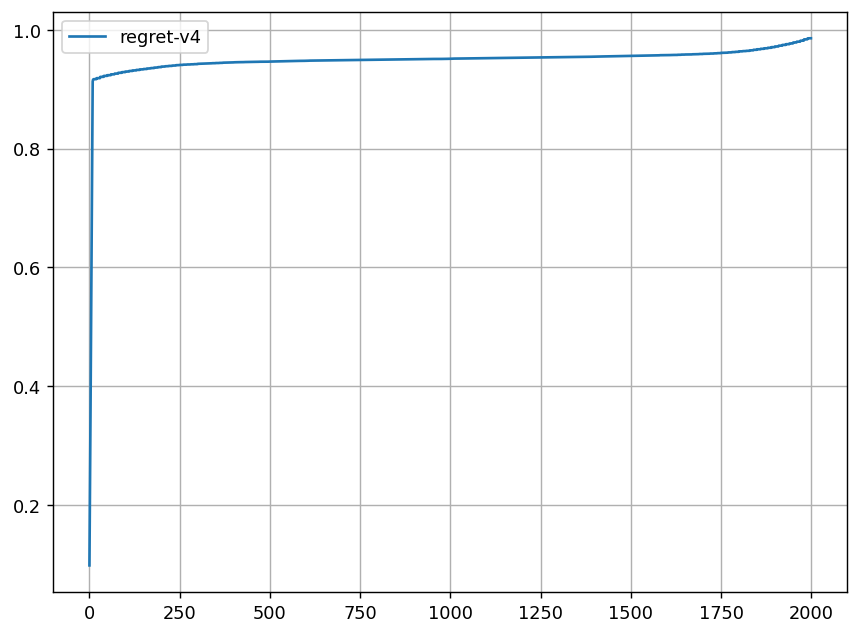

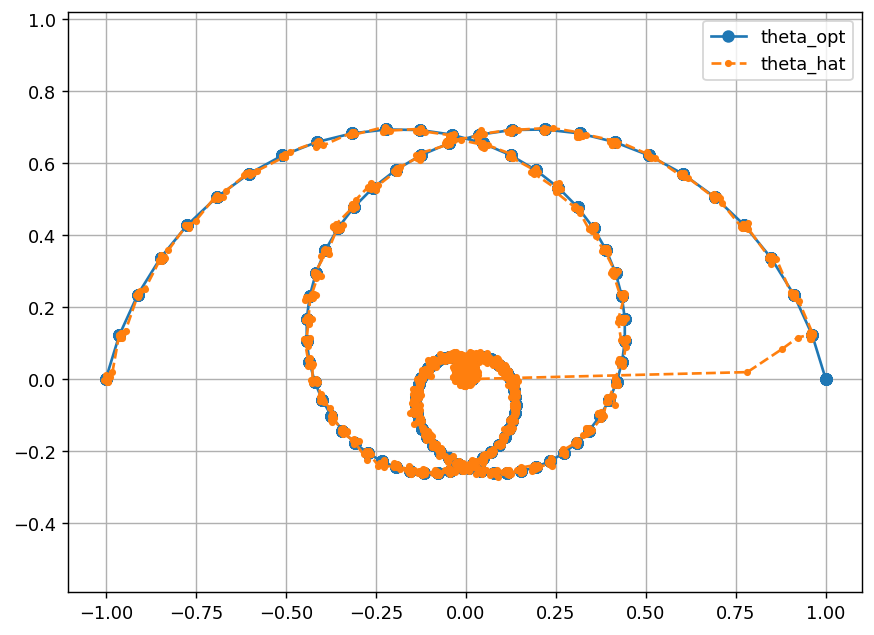

# DIMENSION: 8
running algorithm v4...
regret: 3.7352686


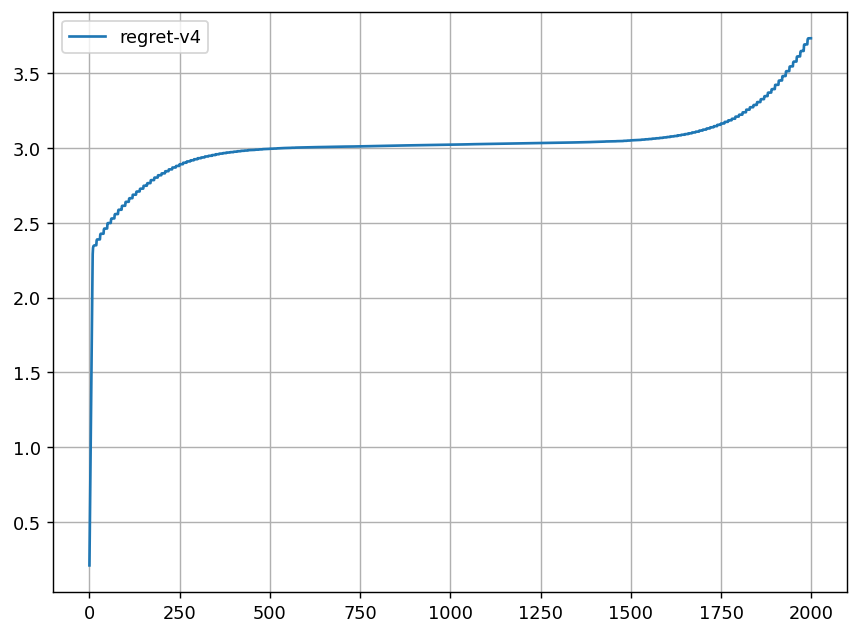

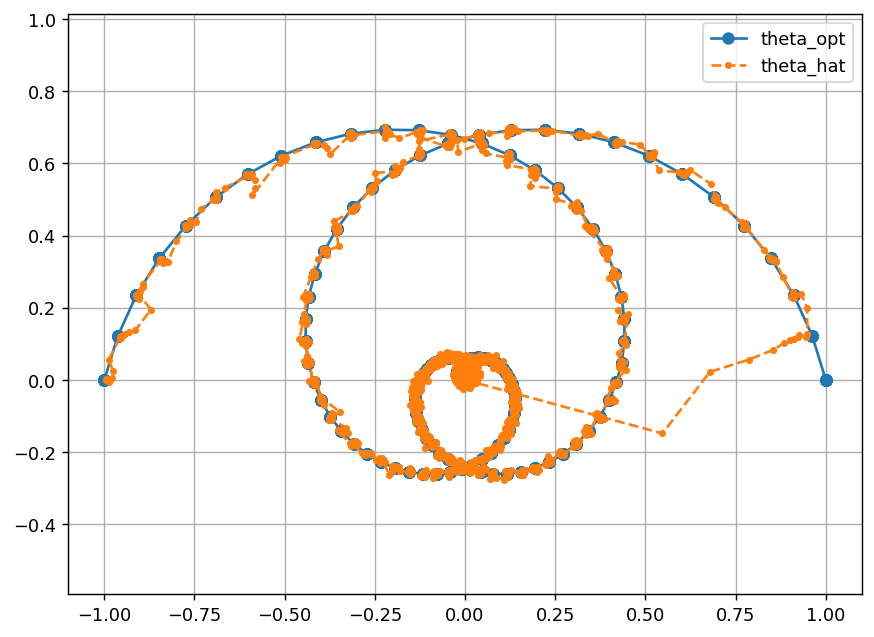

# DIMENSION: 32
running algorithm v4...
regret: 48.065575


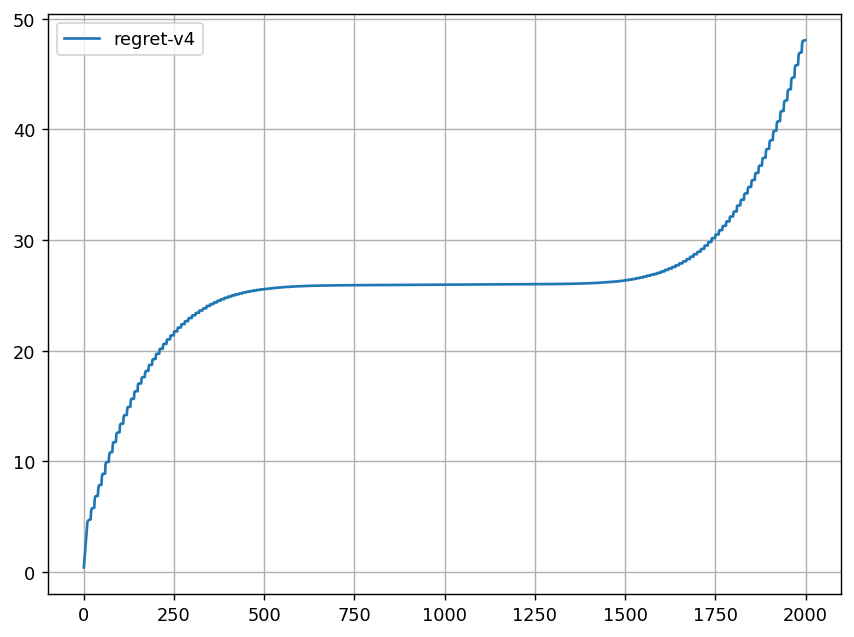

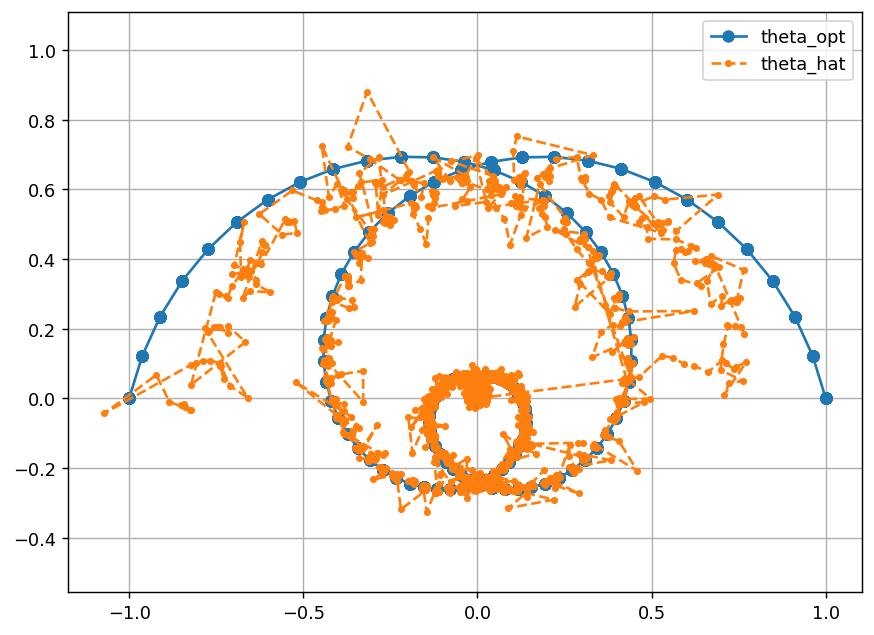

# DIMENSION: 128
running algorithm v4...

In [ ]:
# Sprial experiment (logistic regression, dimension scaling)?

# Settings for camera-ready
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams['savefig.dpi'] = 128

#DIMENSION_LIST = [2, 8]
DIMENSION_LIST = [2, 8, 32, 128, 512]

losses_hat_list = []
losses_opt_list = []
thetas_hat_list = []
thetas_opt_list = []
step_sizes_list = []
regret_list = []

for DIMENSION in DIMENSION_LIST:
  print('# DIMENSION:', DIMENSION)
  BATCH_SIZE = 256
  NUM_STEPS_PER_PHASE = 10
  SIGMA_X = 1.0
  SIGMA_NOISE = 0.1
  MODEL_TYPE = 'logistic_regression'
  BINARY_LABELS = False

  NUM_REVOLUTIONS = 4
  NUM_STEPS = 2000 // NUM_STEPS_PER_PHASE
  angles = np.linspace(0, 2 * np.pi * NUM_REVOLUTIONS, num=NUM_STEPS)
  radius = np.linspace(1, -1, num=NUM_STEPS)
  radius = radius * radius * radius
  theta_stars = []
  for t in range(len(angles)):
    angle = angles[t]
    coords = []
    for d in range(DIMENSION):
      phase = (d // 2) + 1
      if d % 2 == 0:
        coords.append(np.cos(phase * angle))
      else:
        coords.append(np.sin(phase * angle))
    row_vec = radius[t] * np.array(coords)
    theta_stars.append(row_vec)
  theta_stars = np.array(theta_stars)
  X, y, thetas = draw_samples_from_theta_sequence(theta_stars, BATCH_SIZE * NUM_STEPS_PER_PHASE, MODEL_TYPE, SIGMA_X, SIGMA_NOISE, BINARY_LABELS)

  # # Run online learning algorithm (const)
  # learning_rate_schedule = {}
  # learning_rate_schedule['constant'] = {'step_size': STEP_SIZE}
  # print('running algorithm const...')
  # losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  # regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  # print('regret:', regret[-1])
  # losses_hat_list.append(losses_hat)
  # losses_opt_list.append(losses_opt)
  # thetas_opt_list.append(thetas_opt)
  # thetas_hat_list.append(thetas_hat)
  # step_sizes_list.append(step_sizes)
  # regret_list.append(regret)

  learning_rate_schedule = {}
  learning_rate_schedule['our-algorithm-v4'] = {'batch_size': BATCH_SIZE, 'dimension': X.shape[-1], 'D_max': DIMENSION, 'step_size': 1.0 / np.sqrt(DIMENSION)}
  print('running algorithm v4...')
  losses_hat, losses_opt, thetas_hat, thetas_opt, step_sizes = run_online_learning_algorithm(X, y, thetas, BATCH_SIZE, MODEL_TYPE, learning_rate_schedule)
  regret = np.cumsum(np.array(losses_hat) - np.array(losses_opt))
  print('regret:', regret[-1])
  losses_hat_list.append(losses_hat)
  losses_opt_list.append(losses_opt)
  thetas_opt_list.append(thetas_opt)
  thetas_hat_list.append(thetas_hat)
  step_sizes_list.append(step_sizes)
  regret_list.append(regret)

  #plt.plot(regret_list[-2], label='regret-const')
  plt.plot(regret_list[-1], label='regret-v4')
  plt.legend()
  plt.grid()
  plt.show()

  if DIMENSION > 0:
    plt.plot(thetas_opt[:,0], thetas_opt[:,1], linestyle='-', marker='o', label='theta_opt')
    plt.plot(thetas_hat[:,0], thetas_hat[:,1], linestyle='--', marker='.', label='theta_hat')
    plt.xlim(-1.2, 1.2)
    plt.ylim(-0.6, 1.2)
    plt.legend()
    plt.grid()
    plt.axis('equal')
    plt.show()

print('# final plot')

colors = list(matplotlib.colors.TABLEAU_COLORS.keys()) + list(matplotlib.colors.TABLEAU_COLORS.keys())
for i in range(len(DIMENSION_LIST)):
  DIMENSION = DIMENSION_LIST[i]
  const_idx = 2*i
  alg_v3_idx = 2*i + 1
  #plt.plot(regret_list[const_idx], linestyle='-', label=str(STEP_SIZE) + '-const', c=colors[i])
  plt.plot(regret_list[i], linestyle='-', marker='o', markevery=(NUM_STEPS * NUM_STEPS_PER_PHASE)//10, label='d=' + str(DIMENSION), c=colors[i])

plt.grid()
plt.legend(loc='lower center', ncol=len(DIMENSION_LIST))
plt.yscale('log')
plt.ylabel('regret')
plt.xlabel('time t')
plt.show()

# Reset figsize
set_default_matplotlib_figsize()